In [1]:
'''magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
''' Stuff You Need'''
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import pandas as pd

from IPython.core.debugger import set_trace

from pipeline import get_data as get
from pipeline import process_spikes as ps

In [3]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [4]:
''' Complete List of Mice & Behavioral & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)
print(all_mice)

#list of session IDs in order of mouse names
all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], #A3
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], #A4
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'], #A5
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'], #A6
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'], #A7
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2; _6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3; _2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2','052022_record3','052122_record4','052222_record5','052322_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5','062622_record6'], #Y16_1 & 2 not collected
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # end cohort B; Y9 051822_1 excluded
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #A16_4 behavior excluded, both _5 excluded, A16_6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'],
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #MA7_5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions


['A3' 'A4' 'A5' 'A6' 'A7' 'Y2' 'Y3' 'Y4' 'A12' 'A13' 'Y11' 'Y16' 'Y17'
 'Y18' 'Y19' 'Y9' 'A14' 'A15' 'A16' 'A17' 'A18' 'MA1F' 'MA2F' 'MA3M'
 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F' 'MA10F' 'Y20' 'Y21' 'Y22' 'Y23'
 'Y24' 'A19' 'A20' 'A22' 'A23' 'A24' 'Y25' 'Y26' 'Y27' 'Y28']


In [5]:
''' Load MATLAB Data, Filter, & Save Formatted Data as .NPY'''

#define which mice & sessions to load
mice = all_mice
sessions = all_sessions

'''    
# Or select particular mice & sessions
mice = ['Y11','Y9'] #all_mice
sessions = [['050722_record3'],['051922_record2']] #all_sessions

# Or select mice based on task, cohort, etc.
#mice , mice_ind, _  = np.intersect1d(all_mice,np.union1d(cohorta_mice, cohortb_mice), return_indices = True) # RF mice
#mice , mice_ind, _  = np.intersect1d(all_mice,np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])
'''

for m, session in zip(mice, sessions):
    for s in session:
        
        print('loading {}_{}...'.format(m, s))
        d = {}
        folder = 'C:/Users/Python/Desktop/Dryad/mat_files/'
        data_file = m + '_' + s + '.mat'  
        
        # load data & check keys
        dat = get.loadmat_sbx(folder + data_file)
        #print(dat.keys())
        d['raw'] = dat

        # get behavioral params
        raw = d['raw']
        posx = raw['posx']
        post = raw['post']
        d['raw']['trial'] = d['raw']['trial'] - 1 #zero index trial number
        trial = raw['trial']

        #check for skipped/corrected trials; if so, correct
        try:
            _ = raw['correctedtrial'].shape
            d['raw']['correctedtrial'] = d['raw']['correctedtrial'] - 1
            correctedtrial = raw['correctedtrial']
        except KeyError:
            print('No skipped or corrected trials')
            
        # ensure that VR frame rate has been correctly interpolated during syncing    
        dt = np.unique(np.round(np.diff(post),4))

        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
            dt_to_trash = np.where(np.diff(post) == 0)[0]
        else:
            dt_to_trash = [] 

        # calculate speed on each VR frame
        speed = get.getSpeed(posx, dt)
        raw['speed'] = speed

        # get neural params
        sp = raw['sp']
        cgs = sp['cgs'].copy() #classification
        cids = sp['cids'].copy() # cluster IDs
        spiket = sp['st'].copy()
        cluster_id = sp['clu'].copy()
        cells = cids[cgs == 2] # get IDs of good cells only
        d['raw']['cells'] = cells

        # format spike and behavioral data
        try:
            _ = raw['correctedtrial'].shape
            A = np.column_stack((posx, speed, correctedtrial,  post))
            print('Corrected trials saved')
        except KeyError:
            A = np.column_stack((posx, speed, trial, post))

        B = np.zeros((A.shape[0], cells.shape[0]))
        print('sesh ' + m  + s + ' spike matrix size pre behavioral filtering = ' + str(B.shape))

        # get spike times
        for i in trange(cells.shape[0]):
            st = spiket[cluster_id == cells[i]]
            B[:, i] = get.spiketrain(post, dt, st)

        # filter spikes & position frames by speed < 2cm/s or out of track limits 
        def find(x):
            return x.nonzero()[0]
        speed_to_trash = find(speed < 2)
        pos_to_trash = find((posx < 0) | (posx > 400))
        trash_idx = np.unique(np.concatenate((dt_to_trash, speed_to_trash, pos_to_trash)))
        keep_idx = np.setdiff1d(np.arange(A.shape[0]), trash_idx)

        A = A[keep_idx, :]
        B = B[keep_idx, :]
        d['raw']['trialfil'] = trial[keep_idx]

        # filter cells by total spikes number > 350
        cell_keep_idx = np.sum(B, axis = 0) > 350
        d['raw']['cellsfil'] = cells[cell_keep_idx]
        B = B[:, cell_keep_idx]

        print('behavioral data structure = ' + str(A.shape))
        print('spike matrix size post behavioral filtering = ' + str(B.shape))
        d['behaviorfil'] = A
        d['spikefil'] = B
        
        # specify file & folder names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        save_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # make a similar folder andchange path name

        # save files
        np.save(save_folder + rawdata_file, d['raw'])
        print('saved raw matlab behavioral data as npy file for mouse ' + m + ' session '+ s)
        np.save(save_folder + spikes_file, d['spikefil'])
        print('saved filtered spikes for mouse ' + m + ' session '+ s)
        np.save(save_folder + behavior_file, d['behaviorfil'])
        print('saved filtered behavior as array for mouse ' + m + ' session '+ s)

loading A3_0122_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A3_0122_record1.mat
No skipped or corrected trials
sesh A30122_record1 spike matrix size pre behavioral filtering = (134794, 284)


100%|███████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 159.41it/s]


behavioral data structure = (120747, 4)
spike matrix size post behavioral filtering = (120747, 266)
saved raw matlab behavioral data as npy file for mouse A3 session 0122_record1
saved filtered spikes for mouse A3 session 0122_record1
saved filtered behavior as array for mouse A3 session 0122_record1
loading A3_0123_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A3_0123_record2.mat
No skipped or corrected trials
sesh A30123_record2 spike matrix size pre behavioral filtering = (155057, 108)


100%|███████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 320.38it/s]


behavioral data structure = (134482, 4)
spike matrix size post behavioral filtering = (134482, 102)
saved raw matlab behavioral data as npy file for mouse A3 session 0123_record2
saved filtered spikes for mouse A3 session 0123_record2
saved filtered behavior as array for mouse A3 session 0123_record2
loading A3_0124_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A3_0124_record3.mat
No skipped or corrected trials
sesh A30124_record3 spike matrix size pre behavioral filtering = (157749, 224)


100%|███████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 232.75it/s]


behavioral data structure = (145317, 4)
spike matrix size post behavioral filtering = (145317, 207)
saved raw matlab behavioral data as npy file for mouse A3 session 0124_record3
saved filtered spikes for mouse A3 session 0124_record3
saved filtered behavior as array for mouse A3 session 0124_record3
loading A3_0125_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A3_0125_record4.mat
No skipped or corrected trials
sesh A30125_record4 spike matrix size pre behavioral filtering = (146070, 644)


100%|███████████████████████████████████████████████████████████████████████████████| 644/644 [00:05<00:00, 128.27it/s]


behavioral data structure = (135796, 4)
spike matrix size post behavioral filtering = (135796, 598)
saved raw matlab behavioral data as npy file for mouse A3 session 0125_record4
saved filtered spikes for mouse A3 session 0125_record4
saved filtered behavior as array for mouse A3 session 0125_record4
loading A3_0126_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A3_0126_record5.mat
No skipped or corrected trials
sesh A30126_record5 spike matrix size pre behavioral filtering = (153104, 85)


100%|█████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 175.36it/s]


behavioral data structure = (143502, 4)
spike matrix size post behavioral filtering = (143502, 82)
saved raw matlab behavioral data as npy file for mouse A3 session 0126_record5
saved filtered spikes for mouse A3 session 0126_record5
saved filtered behavior as array for mouse A3 session 0126_record5
loading A3_0127_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A3_0127_record6.mat
No skipped or corrected trials
sesh A30127_record6 spike matrix size pre behavioral filtering = (128032, 313)


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 262.41it/s]


behavioral data structure = (118340, 4)
spike matrix size post behavioral filtering = (118340, 285)
saved raw matlab behavioral data as npy file for mouse A3 session 0127_record6
saved filtered spikes for mouse A3 session 0127_record6
saved filtered behavior as array for mouse A3 session 0127_record6
loading A4_0122_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A4_0122_record1.mat
No skipped or corrected trials
sesh A40122_record1 spike matrix size pre behavioral filtering = (114286, 262)


100%|███████████████████████████████████████████████████████████████████████████████| 262/262 [00:01<00:00, 238.61it/s]


behavioral data structure = (104648, 4)
spike matrix size post behavioral filtering = (104648, 225)
saved raw matlab behavioral data as npy file for mouse A4 session 0122_record1
saved filtered spikes for mouse A4 session 0122_record1
saved filtered behavior as array for mouse A4 session 0122_record1
loading A4_0123_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A4_0123_record2.mat
No skipped or corrected trials
sesh A40123_record2 spike matrix size pre behavioral filtering = (111432, 197)


100%|███████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 207.48it/s]


behavioral data structure = (99789, 4)
spike matrix size post behavioral filtering = (99789, 188)
saved raw matlab behavioral data as npy file for mouse A4 session 0123_record2
saved filtered spikes for mouse A4 session 0123_record2
saved filtered behavior as array for mouse A4 session 0123_record2
loading A4_0124_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A4_0124_record3.mat
No skipped or corrected trials
sesh A40124_record3 spike matrix size pre behavioral filtering = (101276, 269)


100%|███████████████████████████████████████████████████████████████████████████████| 269/269 [00:01<00:00, 228.77it/s]


behavioral data structure = (90684, 4)
spike matrix size post behavioral filtering = (90684, 254)
saved raw matlab behavioral data as npy file for mouse A4 session 0124_record3
saved filtered spikes for mouse A4 session 0124_record3
saved filtered behavior as array for mouse A4 session 0124_record3
loading A4_0125_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A4_0125_record4.mat
No skipped or corrected trials
sesh A40125_record4 spike matrix size pre behavioral filtering = (105446, 351)


100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:01<00:00, 209.36it/s]


behavioral data structure = (93343, 4)
spike matrix size post behavioral filtering = (93343, 317)
saved raw matlab behavioral data as npy file for mouse A4 session 0125_record4
saved filtered spikes for mouse A4 session 0125_record4
saved filtered behavior as array for mouse A4 session 0125_record4
loading A4_0126_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A4_0126_record5.mat
No skipped or corrected trials
sesh A40126_record5 spike matrix size pre behavioral filtering = (114412, 404)


100%|███████████████████████████████████████████████████████████████████████████████| 404/404 [00:02<00:00, 189.82it/s]


behavioral data structure = (92419, 4)
spike matrix size post behavioral filtering = (92419, 337)
saved raw matlab behavioral data as npy file for mouse A4 session 0126_record5
saved filtered spikes for mouse A4 session 0126_record5
saved filtered behavior as array for mouse A4 session 0126_record5
loading A4_0127_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A4_0127_record6.mat
No skipped or corrected trials
sesh A40127_record6 spike matrix size pre behavioral filtering = (107510, 274)


100%|███████████████████████████████████████████████████████████████████████████████| 274/274 [00:01<00:00, 241.64it/s]


behavioral data structure = (90261, 4)
spike matrix size post behavioral filtering = (90261, 253)
saved raw matlab behavioral data as npy file for mouse A4 session 0127_record6
saved filtered spikes for mouse A4 session 0127_record6
saved filtered behavior as array for mouse A4 session 0127_record6
loading A5_0401_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A5_0401_record1.mat
No skipped or corrected trials
sesh A50401_record1 spike matrix size pre behavioral filtering = (398292, 187)


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:02<00:00, 80.16it/s]


behavioral data structure = (207065, 4)
spike matrix size post behavioral filtering = (207065, 157)
saved raw matlab behavioral data as npy file for mouse A5 session 0401_record1
saved filtered spikes for mouse A5 session 0401_record1
saved filtered behavior as array for mouse A5 session 0401_record1
loading A5_0401_record2b...
C:/Users/Python/Desktop/Dryad/mat_files/A5_0401_record2b.mat
No skipped or corrected trials
sesh A50401_record2b spike matrix size pre behavioral filtering = (345741, 160)


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:01<00:00, 85.52it/s]


behavioral data structure = (181770, 4)
spike matrix size post behavioral filtering = (181770, 144)
saved raw matlab behavioral data as npy file for mouse A5 session 0401_record2b
saved filtered spikes for mouse A5 session 0401_record2b
saved filtered behavior as array for mouse A5 session 0401_record2b
loading A5_0403_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A5_0403_record3.mat
No skipped or corrected trials
sesh A50403_record3 spike matrix size pre behavioral filtering = (292115, 163)


100%|███████████████████████████████████████████████████████████████████████████████| 163/163 [00:01<00:00, 129.82it/s]


behavioral data structure = (190151, 4)
spike matrix size post behavioral filtering = (190151, 154)
saved raw matlab behavioral data as npy file for mouse A5 session 0403_record3
saved filtered spikes for mouse A5 session 0403_record3
saved filtered behavior as array for mouse A5 session 0403_record3
loading A5_0404_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A5_0404_record4.mat
No skipped or corrected trials
sesh A50404_record4 spike matrix size pre behavioral filtering = (267536, 230)


100%|███████████████████████████████████████████████████████████████████████████████| 230/230 [00:02<00:00, 110.08it/s]


behavioral data structure = (172204, 4)
spike matrix size post behavioral filtering = (172204, 217)
saved raw matlab behavioral data as npy file for mouse A5 session 0404_record4
saved filtered spikes for mouse A5 session 0404_record4
saved filtered behavior as array for mouse A5 session 0404_record4
loading A5_0405_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A5_0405_record5.mat
No skipped or corrected trials
sesh A50405_record5 spike matrix size pre behavioral filtering = (265153, 171)


100%|███████████████████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 116.80it/s]


behavioral data structure = (164477, 4)
spike matrix size post behavioral filtering = (164477, 158)
saved raw matlab behavioral data as npy file for mouse A5 session 0405_record5
saved filtered spikes for mouse A5 session 0405_record5
saved filtered behavior as array for mouse A5 session 0405_record5
loading A5_0406_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A5_0406_record6.mat
No skipped or corrected trials
sesh A50406_record6 spike matrix size pre behavioral filtering = (243475, 184)


100%|███████████████████████████████████████████████████████████████████████████████| 184/184 [00:01<00:00, 137.07it/s]


behavioral data structure = (156924, 4)
spike matrix size post behavioral filtering = (156924, 172)
saved raw matlab behavioral data as npy file for mouse A5 session 0406_record6
saved filtered spikes for mouse A5 session 0406_record6
saved filtered behavior as array for mouse A5 session 0406_record6
loading A6_0401_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A6_0401_record1.mat
No skipped or corrected trials
sesh A60401_record1 spike matrix size pre behavioral filtering = (164402, 264)


100%|███████████████████████████████████████████████████████████████████████████████| 264/264 [00:01<00:00, 163.20it/s]


behavioral data structure = (126403, 4)
spike matrix size post behavioral filtering = (126403, 246)
saved raw matlab behavioral data as npy file for mouse A6 session 0401_record1
saved filtered spikes for mouse A6 session 0401_record1
saved filtered behavior as array for mouse A6 session 0401_record1
loading A6_0402_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A6_0402_record2.mat
No skipped or corrected trials
sesh A60402_record2 spike matrix size pre behavioral filtering = (358442, 105)


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 89.98it/s]


behavioral data structure = (198328, 4)
spike matrix size post behavioral filtering = (198328, 99)
saved raw matlab behavioral data as npy file for mouse A6 session 0402_record2
saved filtered spikes for mouse A6 session 0402_record2
saved filtered behavior as array for mouse A6 session 0402_record2
loading A6_0403_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A6_0403_record3.mat
No skipped or corrected trials
sesh A60403_record3 spike matrix size pre behavioral filtering = (141101, 98)


100%|█████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 212.69it/s]


behavioral data structure = (130786, 4)
spike matrix size post behavioral filtering = (130786, 96)
saved raw matlab behavioral data as npy file for mouse A6 session 0403_record3
saved filtered spikes for mouse A6 session 0403_record3
saved filtered behavior as array for mouse A6 session 0403_record3
loading A6_0404_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A6_0404_record4.mat
No skipped or corrected trials
sesh A60404_record4 spike matrix size pre behavioral filtering = (158544, 265)


100%|███████████████████████████████████████████████████████████████████████████████| 265/265 [00:01<00:00, 191.16it/s]


behavioral data structure = (134392, 4)
spike matrix size post behavioral filtering = (134392, 234)
saved raw matlab behavioral data as npy file for mouse A6 session 0404_record4
saved filtered spikes for mouse A6 session 0404_record4
saved filtered behavior as array for mouse A6 session 0404_record4
loading A6_0405_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A6_0405_record5.mat
No skipped or corrected trials
sesh A60405_record5 spike matrix size pre behavioral filtering = (124626, 183)


100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 305.80it/s]


behavioral data structure = (118181, 4)
spike matrix size post behavioral filtering = (118181, 164)
saved raw matlab behavioral data as npy file for mouse A6 session 0405_record5
saved filtered spikes for mouse A6 session 0405_record5
saved filtered behavior as array for mouse A6 session 0405_record5
loading A6_0406_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A6_0406_record6.mat
No skipped or corrected trials
sesh A60406_record6 spike matrix size pre behavioral filtering = (111787, 163)


100%|███████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 312.50it/s]


behavioral data structure = (96552, 4)
spike matrix size post behavioral filtering = (96552, 146)
saved raw matlab behavioral data as npy file for mouse A6 session 0406_record6
saved filtered spikes for mouse A6 session 0406_record6
saved filtered behavior as array for mouse A6 session 0406_record6
loading A7_0414_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A7_0414_record1.mat
No skipped or corrected trials
sesh A70414_record1 spike matrix size pre behavioral filtering = (162659, 148)


100%|███████████████████████████████████████████████████████████████████████████████| 148/148 [00:01<00:00, 139.34it/s]


behavioral data structure = (146516, 4)
spike matrix size post behavioral filtering = (146516, 144)
saved raw matlab behavioral data as npy file for mouse A7 session 0414_record1
saved filtered spikes for mouse A7 session 0414_record1
saved filtered behavior as array for mouse A7 session 0414_record1
loading A7_0415_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A7_0415_record2.mat
No skipped or corrected trials
sesh A70415_record2 spike matrix size pre behavioral filtering = (128570, 420)


100%|███████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 138.30it/s]


behavioral data structure = (122378, 4)
spike matrix size post behavioral filtering = (122378, 404)
saved raw matlab behavioral data as npy file for mouse A7 session 0415_record2
saved filtered spikes for mouse A7 session 0415_record2
saved filtered behavior as array for mouse A7 session 0415_record2
loading A7_0416_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A7_0416_record3.mat
No skipped or corrected trials
sesh A70416_record3 spike matrix size pre behavioral filtering = (117504, 300)


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 222.82it/s]


behavioral data structure = (112310, 4)
spike matrix size post behavioral filtering = (112310, 286)
saved raw matlab behavioral data as npy file for mouse A7 session 0416_record3
saved filtered spikes for mouse A7 session 0416_record3
saved filtered behavior as array for mouse A7 session 0416_record3
loading A7_0417_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A7_0417_record4.mat
No skipped or corrected trials
sesh A70417_record4 spike matrix size pre behavioral filtering = (137318, 425)


100%|███████████████████████████████████████████████████████████████████████████████| 425/425 [00:02<00:00, 162.15it/s]


behavioral data structure = (116679, 4)
spike matrix size post behavioral filtering = (116679, 383)
saved raw matlab behavioral data as npy file for mouse A7 session 0417_record4
saved filtered spikes for mouse A7 session 0417_record4
saved filtered behavior as array for mouse A7 session 0417_record4
loading A7_0418_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A7_0418_record5.mat
No skipped or corrected trials
sesh A70418_record5 spike matrix size pre behavioral filtering = (138751, 263)


100%|███████████████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 170.35it/s]


behavioral data structure = (124142, 4)
spike matrix size post behavioral filtering = (124142, 255)
saved raw matlab behavioral data as npy file for mouse A7 session 0418_record5
saved filtered spikes for mouse A7 session 0418_record5
saved filtered behavior as array for mouse A7 session 0418_record5
loading A7_0419_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A7_0419_record6.mat
No skipped or corrected trials
sesh A70419_record6 spike matrix size pre behavioral filtering = (134246, 228)


100%|███████████████████████████████████████████████████████████████████████████████| 228/228 [00:01<00:00, 149.61it/s]


behavioral data structure = (127640, 4)
spike matrix size post behavioral filtering = (127640, 219)
saved raw matlab behavioral data as npy file for mouse A7 session 0419_record6
saved filtered spikes for mouse A7 session 0419_record6
saved filtered behavior as array for mouse A7 session 0419_record6
loading Y2_1024_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y2_1024_record1.mat
No skipped or corrected trials
sesh Y21024_record1 spike matrix size pre behavioral filtering = (275155, 172)


100%|███████████████████████████████████████████████████████████████████████████████| 172/172 [00:01<00:00, 131.55it/s]


behavioral data structure = (177066, 4)
spike matrix size post behavioral filtering = (177066, 153)
saved raw matlab behavioral data as npy file for mouse Y2 session 1024_record1
saved filtered spikes for mouse Y2 session 1024_record1
saved filtered behavior as array for mouse Y2 session 1024_record1
loading Y2_1025_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y2_1025_record2.mat
No skipped or corrected trials
sesh Y21025_record2 spike matrix size pre behavioral filtering = (284768, 83)


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 151.32it/s]


behavioral data structure = (177057, 4)
spike matrix size post behavioral filtering = (177057, 77)
saved raw matlab behavioral data as npy file for mouse Y2 session 1025_record2
saved filtered spikes for mouse Y2 session 1025_record2
saved filtered behavior as array for mouse Y2 session 1025_record2
loading Y2_1026_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y2_1026_record3.mat
No skipped or corrected trials
sesh Y21026_record3 spike matrix size pre behavioral filtering = (355383, 110)


100%|███████████████████████████████████████████████████████████████████████████████| 110/110 [00:01<00:00, 104.25it/s]


behavioral data structure = (156043, 4)
spike matrix size post behavioral filtering = (156043, 107)
saved raw matlab behavioral data as npy file for mouse Y2 session 1026_record3
saved filtered spikes for mouse Y2 session 1026_record3
saved filtered behavior as array for mouse Y2 session 1026_record3
loading Y2_1027_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y2_1027_record4.mat
No skipped or corrected trials
sesh Y21027_record4 spike matrix size pre behavioral filtering = (205008, 189)


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:02<00:00, 77.30it/s]


behavioral data structure = (133873, 4)
spike matrix size post behavioral filtering = (133873, 180)
saved raw matlab behavioral data as npy file for mouse Y2 session 1027_record4
saved filtered spikes for mouse Y2 session 1027_record4
saved filtered behavior as array for mouse Y2 session 1027_record4
loading Y2_1028_record5_2...
C:/Users/Python/Desktop/Dryad/mat_files/Y2_1028_record5_2.mat
No skipped or corrected trials
sesh Y21028_record5_2 spike matrix size pre behavioral filtering = (177517, 129)


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 102.17it/s]


behavioral data structure = (133092, 4)
spike matrix size post behavioral filtering = (133092, 124)
saved raw matlab behavioral data as npy file for mouse Y2 session 1028_record5_2
saved filtered spikes for mouse Y2 session 1028_record5_2
saved filtered behavior as array for mouse Y2 session 1028_record5_2
loading Y3_1016_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y3_1016_record1.mat
No skipped or corrected trials
sesh Y31016_record1 spike matrix size pre behavioral filtering = (468518, 299)


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:04<00:00, 73.38it/s]


behavioral data structure = (173963, 4)
spike matrix size post behavioral filtering = (173963, 239)
saved raw matlab behavioral data as npy file for mouse Y3 session 1016_record1
saved filtered spikes for mouse Y3 session 1016_record1
saved filtered behavior as array for mouse Y3 session 1016_record1
loading Y3_1019_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y3_1019_record3.mat
No skipped or corrected trials
sesh Y31019_record3 spike matrix size pre behavioral filtering = (211506, 99)


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 205.51it/s]


behavioral data structure = (141292, 4)
spike matrix size post behavioral filtering = (141292, 93)
saved raw matlab behavioral data as npy file for mouse Y3 session 1019_record3
saved filtered spikes for mouse Y3 session 1019_record3
saved filtered behavior as array for mouse Y3 session 1019_record3
loading Y3_1020_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y3_1020_record4.mat
No skipped or corrected trials
sesh Y31020_record4 spike matrix size pre behavioral filtering = (308898, 194)


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:02<00:00, 90.31it/s]


behavioral data structure = (183583, 4)
spike matrix size post behavioral filtering = (183583, 184)
saved raw matlab behavioral data as npy file for mouse Y3 session 1020_record4
saved filtered spikes for mouse Y3 session 1020_record4
saved filtered behavior as array for mouse Y3 session 1020_record4
loading Y3_1021_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y3_1021_record5.mat
No skipped or corrected trials
sesh Y31021_record5 spike matrix size pre behavioral filtering = (151488, 256)


100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 149.63it/s]


behavioral data structure = (130805, 4)
spike matrix size post behavioral filtering = (130805, 238)
saved raw matlab behavioral data as npy file for mouse Y3 session 1021_record5
saved filtered spikes for mouse Y3 session 1021_record5
saved filtered behavior as array for mouse Y3 session 1021_record5
loading Y3_1022_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y3_1022_record6.mat
No skipped or corrected trials
sesh Y31022_record6 spike matrix size pre behavioral filtering = (290542, 272)


100%|████████████████████████████████████████████████████████████████████████████████| 272/272 [00:02<00:00, 95.93it/s]


behavioral data structure = (187724, 4)
spike matrix size post behavioral filtering = (187724, 257)
saved raw matlab behavioral data as npy file for mouse Y3 session 1022_record6
saved filtered spikes for mouse Y3 session 1022_record6
saved filtered behavior as array for mouse Y3 session 1022_record6
loading Y4_1114_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y4_1114_record1.mat
No skipped or corrected trials
sesh Y41114_record1 spike matrix size pre behavioral filtering = (187748, 188)


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 177.67it/s]


behavioral data structure = (133116, 4)
spike matrix size post behavioral filtering = (133116, 175)
saved raw matlab behavioral data as npy file for mouse Y4 session 1114_record1
saved filtered spikes for mouse Y4 session 1114_record1
saved filtered behavior as array for mouse Y4 session 1114_record1
loading Y4_1115_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y4_1115_record2.mat
No skipped or corrected trials
sesh Y41115_record2 spike matrix size pre behavioral filtering = (152700, 133)


100%|███████████████████████████████████████████████████████████████████████████████| 133/133 [00:01<00:00, 126.40it/s]


behavioral data structure = (128930, 4)
spike matrix size post behavioral filtering = (128930, 127)
saved raw matlab behavioral data as npy file for mouse Y4 session 1115_record2
saved filtered spikes for mouse Y4 session 1115_record2
saved filtered behavior as array for mouse Y4 session 1115_record2
loading Y4_1116_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y4_1116_record3.mat
No skipped or corrected trials
sesh Y41116_record3 spike matrix size pre behavioral filtering = (187741, 97)


100%|█████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 191.83it/s]


behavioral data structure = (149188, 4)
spike matrix size post behavioral filtering = (149188, 90)
saved raw matlab behavioral data as npy file for mouse Y4 session 1116_record3
saved filtered spikes for mouse Y4 session 1116_record3
saved filtered behavior as array for mouse Y4 session 1116_record3
loading Y4_1117_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y4_1117_record4.mat
No skipped or corrected trials
sesh Y41117_record4 spike matrix size pre behavioral filtering = (174683, 327)


100%|███████████████████████████████████████████████████████████████████████████████| 327/327 [00:02<00:00, 125.34it/s]


behavioral data structure = (141457, 4)
spike matrix size post behavioral filtering = (141457, 308)
saved raw matlab behavioral data as npy file for mouse Y4 session 1117_record4
saved filtered spikes for mouse Y4 session 1117_record4
saved filtered behavior as array for mouse Y4 session 1117_record4
loading Y4_1118_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y4_1118_record5.mat
No skipped or corrected trials
sesh Y41118_record5 spike matrix size pre behavioral filtering = (146827, 437)


100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:02<00:00, 149.65it/s]


behavioral data structure = (126408, 4)
spike matrix size post behavioral filtering = (126408, 402)
saved raw matlab behavioral data as npy file for mouse Y4 session 1118_record5
saved filtered spikes for mouse Y4 session 1118_record5
saved filtered behavior as array for mouse Y4 session 1118_record5
loading Y4_1119_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y4_1119_record6.mat
No skipped or corrected trials
sesh Y41119_record6 spike matrix size pre behavioral filtering = (143397, 168)


100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 206.68it/s]


behavioral data structure = (133967, 4)
spike matrix size post behavioral filtering = (133967, 165)
saved raw matlab behavioral data as npy file for mouse Y4 session 1119_record6
saved filtered spikes for mouse Y4 session 1119_record6
saved filtered behavior as array for mouse Y4 session 1119_record6
loading A12_051822_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A12_051822_record1.mat
Corrected trials saved
sesh A12051822_record1 spike matrix size pre behavioral filtering = (405948, 236)


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:03<00:00, 76.01it/s]


behavioral data structure = (183292, 4)
spike matrix size post behavioral filtering = (183292, 222)
saved raw matlab behavioral data as npy file for mouse A12 session 051822_record1
saved filtered spikes for mouse A12 session 051822_record1
saved filtered behavior as array for mouse A12 session 051822_record1
loading A12_051922_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A12_051922_record2.mat
Corrected trials saved
sesh A12051922_record2 spike matrix size pre behavioral filtering = (294092, 371)


100%|████████████████████████████████████████████████████████████████████████████████| 371/371 [00:04<00:00, 87.91it/s]


behavioral data structure = (198884, 4)
spike matrix size post behavioral filtering = (198884, 366)
saved raw matlab behavioral data as npy file for mouse A12 session 051922_record2
saved filtered spikes for mouse A12 session 051922_record2
saved filtered behavior as array for mouse A12 session 051922_record2
loading A12_052022_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A12_052022_record3.mat
Corrected trials saved
sesh A12052022_record3 spike matrix size pre behavioral filtering = (230849, 232)


100%|███████████████████████████████████████████████████████████████████████████████| 232/232 [00:01<00:00, 120.53it/s]


behavioral data structure = (193752, 4)
spike matrix size post behavioral filtering = (193752, 223)
saved raw matlab behavioral data as npy file for mouse A12 session 052022_record3
saved filtered spikes for mouse A12 session 052022_record3
saved filtered behavior as array for mouse A12 session 052022_record3
loading A12_052122_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A12_052122_record4.mat
Corrected trials saved
sesh A12052122_record4 spike matrix size pre behavioral filtering = (211075, 407)


100%|███████████████████████████████████████████████████████████████████████████████| 407/407 [00:02<00:00, 165.08it/s]


behavioral data structure = (171696, 4)
spike matrix size post behavioral filtering = (171696, 378)
saved raw matlab behavioral data as npy file for mouse A12 session 052122_record4
saved filtered spikes for mouse A12 session 052122_record4
saved filtered behavior as array for mouse A12 session 052122_record4
loading A12_052222_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A12_052222_record5.mat
Corrected trials saved
sesh A12052222_record5 spike matrix size pre behavioral filtering = (221902, 207)


100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:01<00:00, 146.68it/s]


behavioral data structure = (182695, 4)
spike matrix size post behavioral filtering = (182695, 196)
saved raw matlab behavioral data as npy file for mouse A12 session 052222_record5
saved filtered spikes for mouse A12 session 052222_record5
saved filtered behavior as array for mouse A12 session 052222_record5
loading A12_052322_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A12_052322_record6.mat
Corrected trials saved
sesh A12052322_record6 spike matrix size pre behavioral filtering = (191559, 99)


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 214.86it/s]


behavioral data structure = (155652, 4)
spike matrix size post behavioral filtering = (155652, 92)
saved raw matlab behavioral data as npy file for mouse A12 session 052322_record6
saved filtered spikes for mouse A12 session 052322_record6
saved filtered behavior as array for mouse A12 session 052322_record6
loading A13_050522_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A13_050522_record1.mat
Corrected trials saved
sesh A13050522_record1 spike matrix size pre behavioral filtering = (494329, 351)


100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [00:03<00:00, 92.52it/s]


behavioral data structure = (205283, 4)
spike matrix size post behavioral filtering = (205283, 303)
saved raw matlab behavioral data as npy file for mouse A13 session 050522_record1
saved filtered spikes for mouse A13 session 050522_record1
saved filtered behavior as array for mouse A13 session 050522_record1
loading A13_050622_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A13_050622_record2.mat
Corrected trials saved
sesh A13050622_record2 spike matrix size pre behavioral filtering = (256276, 765)


100%|███████████████████████████████████████████████████████████████████████████████| 765/765 [00:07<00:00, 105.06it/s]


behavioral data structure = (199702, 4)
spike matrix size post behavioral filtering = (199702, 705)
saved raw matlab behavioral data as npy file for mouse A13 session 050622_record2
saved filtered spikes for mouse A13 session 050622_record2
saved filtered behavior as array for mouse A13 session 050622_record2
loading A13_050722_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A13_050722_record3.mat
No skipped or corrected trials
sesh A13050722_record3 spike matrix size pre behavioral filtering = (222436, 356)


100%|███████████████████████████████████████████████████████████████████████████████| 356/356 [00:02<00:00, 121.00it/s]


behavioral data structure = (184140, 4)
spike matrix size post behavioral filtering = (184140, 350)
saved raw matlab behavioral data as npy file for mouse A13 session 050722_record3
saved filtered spikes for mouse A13 session 050722_record3
saved filtered behavior as array for mouse A13 session 050722_record3
loading A13_050822_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A13_050822_record4.mat
No skipped or corrected trials
sesh A13050822_record4 spike matrix size pre behavioral filtering = (202989, 211)


100%|███████████████████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 139.55it/s]


behavioral data structure = (175368, 4)
spike matrix size post behavioral filtering = (175368, 206)
saved raw matlab behavioral data as npy file for mouse A13 session 050822_record4
saved filtered spikes for mouse A13 session 050822_record4
saved filtered behavior as array for mouse A13 session 050822_record4
loading A13_050922_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A13_050922_record5.mat
No skipped or corrected trials
sesh A13050922_record5 spike matrix size pre behavioral filtering = (213907, 214)


100%|███████████████████████████████████████████████████████████████████████████████| 214/214 [00:01<00:00, 179.41it/s]


behavioral data structure = (182964, 4)
spike matrix size post behavioral filtering = (182964, 207)
saved raw matlab behavioral data as npy file for mouse A13 session 050922_record5
saved filtered spikes for mouse A13 session 050922_record5
saved filtered behavior as array for mouse A13 session 050922_record5
loading A13_051022_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A13_051022_record6.mat
Corrected trials saved
sesh A13051022_record6 spike matrix size pre behavioral filtering = (198888, 300)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 99.24it/s]


behavioral data structure = (184812, 4)
spike matrix size post behavioral filtering = (184812, 298)
saved raw matlab behavioral data as npy file for mouse A13 session 051022_record6
saved filtered spikes for mouse A13 session 051022_record6
saved filtered behavior as array for mouse A13 session 051022_record6
loading Y11_050522_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y11_050522_record1.mat
Corrected trials saved
sesh Y11050522_record1 spike matrix size pre behavioral filtering = (321751, 303)


100%|████████████████████████████████████████████████████████████████████████████████| 303/303 [00:03<00:00, 90.47it/s]


behavioral data structure = (231206, 4)
spike matrix size post behavioral filtering = (231206, 292)
saved raw matlab behavioral data as npy file for mouse Y11 session 050522_record1
saved filtered spikes for mouse Y11 session 050522_record1
saved filtered behavior as array for mouse Y11 session 050522_record1
loading Y11_050622_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y11_050622_record2.mat
Corrected trials saved
sesh Y11050622_record2 spike matrix size pre behavioral filtering = (515766, 639)


100%|████████████████████████████████████████████████████████████████████████████████| 639/639 [00:16<00:00, 37.76it/s]


behavioral data structure = (230167, 4)
spike matrix size post behavioral filtering = (230167, 592)
saved raw matlab behavioral data as npy file for mouse Y11 session 050622_record2
saved filtered spikes for mouse Y11 session 050622_record2
saved filtered behavior as array for mouse Y11 session 050622_record2
loading Y11_050722_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y11_050722_record3.mat
Corrected trials saved
sesh Y11050722_record3 spike matrix size pre behavioral filtering = (291188, 464)


100%|████████████████████████████████████████████████████████████████████████████████| 464/464 [00:05<00:00, 77.81it/s]


behavioral data structure = (213358, 4)
spike matrix size post behavioral filtering = (213358, 437)
saved raw matlab behavioral data as npy file for mouse Y11 session 050722_record3
saved filtered spikes for mouse Y11 session 050722_record3
saved filtered behavior as array for mouse Y11 session 050722_record3
loading Y11_050822_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y11_050822_record4.mat
No skipped or corrected trials
sesh Y11050822_record4 spike matrix size pre behavioral filtering = (230467, 316)


100%|███████████████████████████████████████████████████████████████████████████████| 316/316 [00:03<00:00, 100.49it/s]


behavioral data structure = (184575, 4)
spike matrix size post behavioral filtering = (184575, 309)
saved raw matlab behavioral data as npy file for mouse Y11 session 050822_record4
saved filtered spikes for mouse Y11 session 050822_record4
saved filtered behavior as array for mouse Y11 session 050822_record4
loading Y11_051022_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y11_051022_record6.mat
No skipped or corrected trials
sesh Y11051022_record6 spike matrix size pre behavioral filtering = (214388, 391)


100%|███████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 118.01it/s]


behavioral data structure = (164731, 4)
spike matrix size post behavioral filtering = (164731, 363)
saved raw matlab behavioral data as npy file for mouse Y11 session 051022_record6
saved filtered spikes for mouse Y11 session 051022_record6
saved filtered behavior as array for mouse Y11 session 051022_record6
loading Y16_062222_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y16_062222_record3.mat
No skipped or corrected trials
sesh Y16062222_record3 spike matrix size pre behavioral filtering = (297624, 155)


100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 178.64it/s]


behavioral data structure = (201042, 4)
spike matrix size post behavioral filtering = (201042, 136)
saved raw matlab behavioral data as npy file for mouse Y16 session 062222_record3
saved filtered spikes for mouse Y16 session 062222_record3
saved filtered behavior as array for mouse Y16 session 062222_record3
loading Y16_062322_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y16_062322_record4.mat
Corrected trials saved
sesh Y16062322_record4 spike matrix size pre behavioral filtering = (497211, 237)


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [00:02<00:00, 97.87it/s]


behavioral data structure = (243673, 4)
spike matrix size post behavioral filtering = (243673, 225)
saved raw matlab behavioral data as npy file for mouse Y16 session 062322_record4
saved filtered spikes for mouse Y16 session 062322_record4
saved filtered behavior as array for mouse Y16 session 062322_record4
loading Y16_062522_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y16_062522_record5.mat
No skipped or corrected trials
sesh Y16062522_record5 spike matrix size pre behavioral filtering = (255734, 17)


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 309.75it/s]


behavioral data structure = (172609, 4)
spike matrix size post behavioral filtering = (172609, 12)
saved raw matlab behavioral data as npy file for mouse Y16 session 062522_record5
saved filtered spikes for mouse Y16 session 062522_record5
saved filtered behavior as array for mouse Y16 session 062522_record5
loading Y16_062622_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y16_062622_record6.mat
No skipped or corrected trials
sesh Y16062622_record6 spike matrix size pre behavioral filtering = (240937, 1)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


behavioral data structure = (171479, 4)
spike matrix size post behavioral filtering = (171479, 1)
saved raw matlab behavioral data as npy file for mouse Y16 session 062622_record6
saved filtered spikes for mouse Y16 session 062622_record6
saved filtered behavior as array for mouse Y16 session 062622_record6
loading Y17_062822_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y17_062822_record1.mat
Corrected trials saved
sesh Y17062822_record1 spike matrix size pre behavioral filtering = (629774, 164)


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [00:02<00:00, 79.71it/s]


behavioral data structure = (267088, 4)
spike matrix size post behavioral filtering = (267088, 145)
saved raw matlab behavioral data as npy file for mouse Y17 session 062822_record1
saved filtered spikes for mouse Y17 session 062822_record1
saved filtered behavior as array for mouse Y17 session 062822_record1
loading Y17_062922_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y17_062922_record2.mat
Corrected trials saved
sesh Y17062922_record2 spike matrix size pre behavioral filtering = (404940, 190)


100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [00:02<00:00, 90.89it/s]


behavioral data structure = (226575, 4)
spike matrix size post behavioral filtering = (226575, 177)
saved raw matlab behavioral data as npy file for mouse Y17 session 062922_record2
saved filtered spikes for mouse Y17 session 062922_record2
saved filtered behavior as array for mouse Y17 session 062922_record2
loading Y17_063022_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y17_063022_record3.mat
Corrected trials saved
sesh Y17063022_record3 spike matrix size pre behavioral filtering = (252022, 91)


100%|█████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 169.91it/s]


behavioral data structure = (180285, 4)
spike matrix size post behavioral filtering = (180285, 90)
saved raw matlab behavioral data as npy file for mouse Y17 session 063022_record3
saved filtered spikes for mouse Y17 session 063022_record3
saved filtered behavior as array for mouse Y17 session 063022_record3
loading Y17_070122_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y17_070122_record4.mat
No skipped or corrected trials
sesh Y17070122_record4 spike matrix size pre behavioral filtering = (186887, 381)


100%|███████████████████████████████████████████████████████████████████████████████| 381/381 [00:02<00:00, 138.67it/s]


behavioral data structure = (148514, 4)
spike matrix size post behavioral filtering = (148514, 362)
saved raw matlab behavioral data as npy file for mouse Y17 session 070122_record4
saved filtered spikes for mouse Y17 session 070122_record4
saved filtered behavior as array for mouse Y17 session 070122_record4
loading Y17_070222_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y17_070222_record5.mat
Corrected trials saved
sesh Y17070222_record5 spike matrix size pre behavioral filtering = (223926, 347)


100%|███████████████████████████████████████████████████████████████████████████████| 347/347 [00:03<00:00, 109.06it/s]


behavioral data structure = (167119, 4)
spike matrix size post behavioral filtering = (167119, 321)
saved raw matlab behavioral data as npy file for mouse Y17 session 070222_record5
saved filtered spikes for mouse Y17 session 070222_record5
saved filtered behavior as array for mouse Y17 session 070222_record5
loading Y17_070322_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y17_070322_record6.mat
No skipped or corrected trials
sesh Y17070322_record6 spike matrix size pre behavioral filtering = (178797, 233)


100%|███████████████████████████████████████████████████████████████████████████████| 233/233 [00:01<00:00, 176.59it/s]


behavioral data structure = (146202, 4)
spike matrix size post behavioral filtering = (146202, 225)
saved raw matlab behavioral data as npy file for mouse Y17 session 070322_record6
saved filtered spikes for mouse Y17 session 070322_record6
saved filtered behavior as array for mouse Y17 session 070322_record6
loading Y18_062022_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y18_062022_record1.mat
No skipped or corrected trials
sesh Y18062022_record1 spike matrix size pre behavioral filtering = (329009, 399)


100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:04<00:00, 80.86it/s]


behavioral data structure = (181833, 4)
spike matrix size post behavioral filtering = (181833, 378)
saved raw matlab behavioral data as npy file for mouse Y18 session 062022_record1
saved filtered spikes for mouse Y18 session 062022_record1
saved filtered behavior as array for mouse Y18 session 062022_record1
loading Y18_062122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y18_062122_record2.mat
Corrected trials saved
sesh Y18062122_record2 spike matrix size pre behavioral filtering = (328929, 304)


100%|████████████████████████████████████████████████████████████████████████████████| 304/304 [00:03<00:00, 90.61it/s]


behavioral data structure = (187005, 4)
spike matrix size post behavioral filtering = (187005, 283)
saved raw matlab behavioral data as npy file for mouse Y18 session 062122_record2
saved filtered spikes for mouse Y18 session 062122_record2
saved filtered behavior as array for mouse Y18 session 062122_record2
loading Y18_062222_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y18_062222_record3.mat
No skipped or corrected trials
sesh Y18062222_record3 spike matrix size pre behavioral filtering = (170662, 300)


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 194.68it/s]


behavioral data structure = (135703, 4)
spike matrix size post behavioral filtering = (135703, 273)
saved raw matlab behavioral data as npy file for mouse Y18 session 062222_record3
saved filtered spikes for mouse Y18 session 062222_record3
saved filtered behavior as array for mouse Y18 session 062222_record3
loading Y18_062322_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y18_062322_record4.mat
Corrected trials saved
sesh Y18062322_record4 spike matrix size pre behavioral filtering = (316664, 431)


100%|███████████████████████████████████████████████████████████████████████████████| 431/431 [00:04<00:00, 100.57it/s]


behavioral data structure = (189875, 4)
spike matrix size post behavioral filtering = (189875, 409)
saved raw matlab behavioral data as npy file for mouse Y18 session 062322_record4
saved filtered spikes for mouse Y18 session 062322_record4
saved filtered behavior as array for mouse Y18 session 062322_record4
loading Y18_062522_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y18_062522_record5.mat
No skipped or corrected trials
sesh Y18062522_record5 spike matrix size pre behavioral filtering = (159967, 375)


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 168.77it/s]


behavioral data structure = (128143, 4)
spike matrix size post behavioral filtering = (128143, 357)
saved raw matlab behavioral data as npy file for mouse Y18 session 062522_record5
saved filtered spikes for mouse Y18 session 062522_record5
saved filtered behavior as array for mouse Y18 session 062522_record5
loading Y18_062622_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y18_062622_record6.mat
No skipped or corrected trials
sesh Y18062622_record6 spike matrix size pre behavioral filtering = (146490, 221)


100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 200.54it/s]


behavioral data structure = (120954, 4)
spike matrix size post behavioral filtering = (120954, 210)
saved raw matlab behavioral data as npy file for mouse Y18 session 062622_record6
saved filtered spikes for mouse Y18 session 062622_record6
saved filtered behavior as array for mouse Y18 session 062622_record6
loading Y19_062822_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y19_062822_record1.mat
No skipped or corrected trials
sesh Y19062822_record1 spike matrix size pre behavioral filtering = (463412, 278)


100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [00:03<00:00, 73.86it/s]


behavioral data structure = (201905, 4)
spike matrix size post behavioral filtering = (201905, 246)
saved raw matlab behavioral data as npy file for mouse Y19 session 062822_record1
saved filtered spikes for mouse Y19 session 062822_record1
saved filtered behavior as array for mouse Y19 session 062822_record1
loading Y19_062922_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y19_062922_record2.mat
Corrected trials saved
sesh Y19062922_record2 spike matrix size pre behavioral filtering = (486607, 309)


100%|████████████████████████████████████████████████████████████████████████████████| 309/309 [00:05<00:00, 58.65it/s]


behavioral data structure = (235097, 4)
spike matrix size post behavioral filtering = (235097, 262)
saved raw matlab behavioral data as npy file for mouse Y19 session 062922_record2
saved filtered spikes for mouse Y19 session 062922_record2
saved filtered behavior as array for mouse Y19 session 062922_record2
loading Y19_063022_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y19_063022_record3.mat
Corrected trials saved
sesh Y19063022_record3 spike matrix size pre behavioral filtering = (304263, 299)


100%|███████████████████████████████████████████████████████████████████████████████| 299/299 [00:02<00:00, 121.33it/s]


behavioral data structure = (166587, 4)
spike matrix size post behavioral filtering = (166587, 250)
saved raw matlab behavioral data as npy file for mouse Y19 session 063022_record3
saved filtered spikes for mouse Y19 session 063022_record3
saved filtered behavior as array for mouse Y19 session 063022_record3
loading Y19_070122_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y19_070122_record4.mat
Corrected trials saved
sesh Y19070122_record4 spike matrix size pre behavioral filtering = (262012, 440)


100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:04<00:00, 107.76it/s]


behavioral data structure = (191720, 4)
spike matrix size post behavioral filtering = (191720, 407)
saved raw matlab behavioral data as npy file for mouse Y19 session 070122_record4
saved filtered spikes for mouse Y19 session 070122_record4
saved filtered behavior as array for mouse Y19 session 070122_record4
loading Y19_070222_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y19_070222_record5.mat
Corrected trials saved
sesh Y19070222_record5 spike matrix size pre behavioral filtering = (161580, 369)


100%|███████████████████████████████████████████████████████████████████████████████| 369/369 [00:02<00:00, 165.17it/s]


behavioral data structure = (136456, 4)
spike matrix size post behavioral filtering = (136456, 332)
saved raw matlab behavioral data as npy file for mouse Y19 session 070222_record5
saved filtered spikes for mouse Y19 session 070222_record5
saved filtered behavior as array for mouse Y19 session 070222_record5
loading Y19_070322_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y19_070322_record6.mat
Corrected trials saved
sesh Y19070322_record6 spike matrix size pre behavioral filtering = (149867, 301)


100%|███████████████████████████████████████████████████████████████████████████████| 301/301 [00:01<00:00, 240.11it/s]


behavioral data structure = (130124, 4)
spike matrix size post behavioral filtering = (130124, 268)
saved raw matlab behavioral data as npy file for mouse Y19 session 070322_record6
saved filtered spikes for mouse Y19 session 070322_record6
saved filtered behavior as array for mouse Y19 session 070322_record6
loading Y9_051922_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y9_051922_record2.mat
No skipped or corrected trials
sesh Y9051922_record2 spike matrix size pre behavioral filtering = (377937, 322)


100%|███████████████████████████████████████████████████████████████████████████████| 322/322 [00:02<00:00, 139.47it/s]


behavioral data structure = (126508, 4)
spike matrix size post behavioral filtering = (126508, 201)
saved raw matlab behavioral data as npy file for mouse Y9 session 051922_record2
saved filtered spikes for mouse Y9 session 051922_record2
saved filtered behavior as array for mouse Y9 session 051922_record2
loading Y9_052022_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y9_052022_record3.mat
No skipped or corrected trials
sesh Y9052022_record3 spike matrix size pre behavioral filtering = (253984, 364)


100%|███████████████████████████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 228.97it/s]


behavioral data structure = (41139, 4)
spike matrix size post behavioral filtering = (41139, 109)
saved raw matlab behavioral data as npy file for mouse Y9 session 052022_record3
saved filtered spikes for mouse Y9 session 052022_record3
saved filtered behavior as array for mouse Y9 session 052022_record3
loading A14_083022_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A14_083022_record1.mat
Corrected trials saved
sesh A14083022_record1 spike matrix size pre behavioral filtering = (371301, 225)


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:02<00:00, 75.45it/s]


behavioral data structure = (305002, 4)
spike matrix size post behavioral filtering = (305002, 216)
saved raw matlab behavioral data as npy file for mouse A14 session 083022_record1
saved filtered spikes for mouse A14 session 083022_record1
saved filtered behavior as array for mouse A14 session 083022_record1
loading A14_083122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A14_083122_record2.mat
Corrected trials saved
sesh A14083122_record2 spike matrix size pre behavioral filtering = (446501, 264)


100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:04<00:00, 63.10it/s]


behavioral data structure = (293406, 4)
spike matrix size post behavioral filtering = (293406, 257)
saved raw matlab behavioral data as npy file for mouse A14 session 083122_record2
saved filtered spikes for mouse A14 session 083122_record2
saved filtered behavior as array for mouse A14 session 083122_record2
loading A14_090122_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A14_090122_record3.mat
Corrected trials saved
sesh A14090122_record3 spike matrix size pre behavioral filtering = (326505, 96)


100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 115.55it/s]


behavioral data structure = (286690, 4)
spike matrix size post behavioral filtering = (286690, 93)
saved raw matlab behavioral data as npy file for mouse A14 session 090122_record3
saved filtered spikes for mouse A14 session 090122_record3
saved filtered behavior as array for mouse A14 session 090122_record3
loading A15_083022_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A15_083022_record1.mat
No skipped or corrected trials
sesh A15083022_record1 spike matrix size pre behavioral filtering = (133187, 62)


100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 199.89it/s]


behavioral data structure = (121118, 4)
spike matrix size post behavioral filtering = (121118, 55)
saved raw matlab behavioral data as npy file for mouse A15 session 083022_record1
saved filtered spikes for mouse A15 session 083022_record1
saved filtered behavior as array for mouse A15 session 083022_record1
loading A15_083122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A15_083122_record2.mat
Corrected trials saved
sesh A15083122_record2 spike matrix size pre behavioral filtering = (153245, 298)


100%|███████████████████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 163.82it/s]


behavioral data structure = (129150, 4)
spike matrix size post behavioral filtering = (129150, 284)
saved raw matlab behavioral data as npy file for mouse A15 session 083122_record2
saved filtered spikes for mouse A15 session 083122_record2
saved filtered behavior as array for mouse A15 session 083122_record2
loading A15_090122_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A15_090122_record3.mat
Corrected trials saved
sesh A15090122_record3 spike matrix size pre behavioral filtering = (186770, 321)


100%|███████████████████████████████████████████████████████████████████████████████| 321/321 [00:02<00:00, 143.88it/s]


behavioral data structure = (149503, 4)
spike matrix size post behavioral filtering = (149503, 300)
saved raw matlab behavioral data as npy file for mouse A15 session 090122_record3
saved filtered spikes for mouse A15 session 090122_record3
saved filtered behavior as array for mouse A15 session 090122_record3
loading A15_090222_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A15_090222_record4.mat
Corrected trials saved
sesh A15090222_record4 spike matrix size pre behavioral filtering = (197334, 506)


100%|███████████████████████████████████████████████████████████████████████████████| 506/506 [00:04<00:00, 111.14it/s]


behavioral data structure = (148602, 4)
spike matrix size post behavioral filtering = (148602, 485)
saved raw matlab behavioral data as npy file for mouse A15 session 090222_record4
saved filtered spikes for mouse A15 session 090222_record4
saved filtered behavior as array for mouse A15 session 090222_record4
loading A15_090322_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A15_090322_record5.mat
Corrected trials saved
sesh A15090322_record5 spike matrix size pre behavioral filtering = (179114, 354)


100%|███████████████████████████████████████████████████████████████████████████████| 354/354 [00:02<00:00, 157.61it/s]


behavioral data structure = (140349, 4)
spike matrix size post behavioral filtering = (140349, 326)
saved raw matlab behavioral data as npy file for mouse A15 session 090322_record5
saved filtered spikes for mouse A15 session 090322_record5
saved filtered behavior as array for mouse A15 session 090322_record5
loading A15_090422_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A15_090422_record6.mat
No skipped or corrected trials
sesh A15090422_record6 spike matrix size pre behavioral filtering = (140193, 188)


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 231.00it/s]


behavioral data structure = (114958, 4)
spike matrix size post behavioral filtering = (114958, 171)
saved raw matlab behavioral data as npy file for mouse A15 session 090422_record6
saved filtered spikes for mouse A15 session 090422_record6
saved filtered behavior as array for mouse A15 session 090422_record6
loading A16_083022_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A16_083022_record1.mat
Corrected trials saved
sesh A16083022_record1 spike matrix size pre behavioral filtering = (411441, 297)


100%|████████████████████████████████████████████████████████████████████████████████| 297/297 [00:03<00:00, 90.38it/s]


behavioral data structure = (205799, 4)
spike matrix size post behavioral filtering = (205799, 260)
saved raw matlab behavioral data as npy file for mouse A16 session 083022_record1
saved filtered spikes for mouse A16 session 083022_record1
saved filtered behavior as array for mouse A16 session 083022_record1
loading A16_083122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A16_083122_record2.mat
Corrected trials saved
sesh A16083122_record2 spike matrix size pre behavioral filtering = (256011, 209)


100%|███████████████████████████████████████████████████████████████████████████████| 209/209 [00:01<00:00, 106.92it/s]


behavioral data structure = (186797, 4)
spike matrix size post behavioral filtering = (186797, 195)
saved raw matlab behavioral data as npy file for mouse A16 session 083122_record2
saved filtered spikes for mouse A16 session 083122_record2
saved filtered behavior as array for mouse A16 session 083122_record2
loading A16_090122_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A16_090122_record3.mat
Corrected trials saved
sesh A16090122_record3 spike matrix size pre behavioral filtering = (559679, 47)


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 95.39it/s]


behavioral data structure = (241816, 4)
spike matrix size post behavioral filtering = (241816, 37)
saved raw matlab behavioral data as npy file for mouse A16 session 090122_record3
saved filtered spikes for mouse A16 session 090122_record3
saved filtered behavior as array for mouse A16 session 090122_record3
loading A16_090222_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A16_090222_record4.mat
No skipped or corrected trials
sesh A16090222_record4 spike matrix size pre behavioral filtering = (544123, 233)


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [00:02<00:00, 82.09it/s]


behavioral data structure = (241352, 4)
spike matrix size post behavioral filtering = (241352, 179)
saved raw matlab behavioral data as npy file for mouse A16 session 090222_record4
saved filtered spikes for mouse A16 session 090222_record4
saved filtered behavior as array for mouse A16 session 090222_record4
loading A17_082322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A17_082322_record1.mat
No skipped or corrected trials
sesh A17082322_record1 spike matrix size pre behavioral filtering = (239881, 262)


100%|███████████████████████████████████████████████████████████████████████████████| 262/262 [00:01<00:00, 232.89it/s]


behavioral data structure = (156493, 4)
spike matrix size post behavioral filtering = (156493, 183)
saved raw matlab behavioral data as npy file for mouse A17 session 082322_record1
saved filtered spikes for mouse A17 session 082322_record1
saved filtered behavior as array for mouse A17 session 082322_record1
loading A17_082422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A17_082422_record2.mat
No skipped or corrected trials
sesh A17082422_record2 spike matrix size pre behavioral filtering = (170584, 37)


100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 190.26it/s]


behavioral data structure = (127388, 4)
spike matrix size post behavioral filtering = (127388, 36)
saved raw matlab behavioral data as npy file for mouse A17 session 082422_record2
saved filtered spikes for mouse A17 session 082422_record2
saved filtered behavior as array for mouse A17 session 082422_record2
loading A17_082522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A17_082522_record3.mat
No skipped or corrected trials
sesh A17082522_record3 spike matrix size pre behavioral filtering = (148692, 266)


100%|███████████████████████████████████████████████████████████████████████████████| 266/266 [00:01<00:00, 225.08it/s]


behavioral data structure = (120404, 4)
spike matrix size post behavioral filtering = (120404, 225)
saved raw matlab behavioral data as npy file for mouse A17 session 082522_record3
saved filtered spikes for mouse A17 session 082522_record3
saved filtered behavior as array for mouse A17 session 082522_record3
loading A17_082622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A17_082622_record4.mat
Corrected trials saved
sesh A17082622_record4 spike matrix size pre behavioral filtering = (159132, 213)


100%|███████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 222.70it/s]


behavioral data structure = (125282, 4)
spike matrix size post behavioral filtering = (125282, 163)
saved raw matlab behavioral data as npy file for mouse A17 session 082622_record4
saved filtered spikes for mouse A17 session 082622_record4
saved filtered behavior as array for mouse A17 session 082622_record4
loading A17_082722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A17_082722_record5.mat
Corrected trials saved
sesh A17082722_record5 spike matrix size pre behavioral filtering = (317234, 405)


100%|███████████████████████████████████████████████████████████████████████████████| 405/405 [00:03<00:00, 122.28it/s]


behavioral data structure = (156538, 4)
spike matrix size post behavioral filtering = (156538, 373)
saved raw matlab behavioral data as npy file for mouse A17 session 082722_record5
saved filtered spikes for mouse A17 session 082722_record5
saved filtered behavior as array for mouse A17 session 082722_record5
loading A17_082822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A17_082822_record6.mat
Corrected trials saved
sesh A17082822_record6 spike matrix size pre behavioral filtering = (209701, 221)


100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:01<00:00, 186.53it/s]


behavioral data structure = (149379, 4)
spike matrix size post behavioral filtering = (149379, 184)
saved raw matlab behavioral data as npy file for mouse A17 session 082822_record6
saved filtered spikes for mouse A17 session 082822_record6
saved filtered behavior as array for mouse A17 session 082822_record6
loading A18_082322_record1real...
C:/Users/Python/Desktop/Dryad/mat_files/A18_082322_record1real.mat
No skipped or corrected trials
sesh A18082322_record1real spike matrix size pre behavioral filtering = (208965, 67)


100%|█████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 194.74it/s]


behavioral data structure = (182733, 4)
spike matrix size post behavioral filtering = (182733, 65)
saved raw matlab behavioral data as npy file for mouse A18 session 082322_record1real
saved filtered spikes for mouse A18 session 082322_record1real
saved filtered behavior as array for mouse A18 session 082322_record1real
loading A18_082422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A18_082422_record2.mat
Corrected trials saved
sesh A18082422_record2 spike matrix size pre behavioral filtering = (342332, 557)


100%|████████████████████████████████████████████████████████████████████████████████| 557/557 [00:10<00:00, 52.99it/s]


behavioral data structure = (228244, 4)
spike matrix size post behavioral filtering = (228244, 538)
saved raw matlab behavioral data as npy file for mouse A18 session 082422_record2
saved filtered spikes for mouse A18 session 082422_record2
saved filtered behavior as array for mouse A18 session 082422_record2
loading A18_082522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A18_082522_record3.mat
No skipped or corrected trials
sesh A18082522_record3 spike matrix size pre behavioral filtering = (206244, 524)


100%|███████████████████████████████████████████████████████████████████████████████| 524/524 [00:05<00:00, 103.95it/s]


behavioral data structure = (175015, 4)
spike matrix size post behavioral filtering = (175015, 506)
saved raw matlab behavioral data as npy file for mouse A18 session 082522_record3
saved filtered spikes for mouse A18 session 082522_record3
saved filtered behavior as array for mouse A18 session 082522_record3
loading A18_082622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A18_082622_record4.mat
Corrected trials saved
sesh A18082622_record4 spike matrix size pre behavioral filtering = (256715, 673)


100%|███████████████████████████████████████████████████████████████████████████████| 673/673 [00:06<00:00, 107.20it/s]


behavioral data structure = (192028, 4)
spike matrix size post behavioral filtering = (192028, 649)
saved raw matlab behavioral data as npy file for mouse A18 session 082622_record4
saved filtered spikes for mouse A18 session 082622_record4
saved filtered behavior as array for mouse A18 session 082622_record4
loading A18_082722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A18_082722_record5.mat
Corrected trials saved
sesh A18082722_record5 spike matrix size pre behavioral filtering = (180994, 237)


100%|███████████████████████████████████████████████████████████████████████████████| 237/237 [00:01<00:00, 181.54it/s]


behavioral data structure = (168088, 4)
spike matrix size post behavioral filtering = (168088, 227)
saved raw matlab behavioral data as npy file for mouse A18 session 082722_record5
saved filtered spikes for mouse A18 session 082722_record5
saved filtered behavior as array for mouse A18 session 082722_record5
loading A18_082822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A18_082822_record6.mat
No skipped or corrected trials
sesh A18082822_record6 spike matrix size pre behavioral filtering = (166271, 267)


100%|███████████████████████████████████████████████████████████████████████████████| 267/267 [00:01<00:00, 212.64it/s]


behavioral data structure = (153752, 4)
spike matrix size post behavioral filtering = (153752, 247)
saved raw matlab behavioral data as npy file for mouse A18 session 082822_record6
saved filtered spikes for mouse A18 session 082822_record6
saved filtered behavior as array for mouse A18 session 082822_record6
loading MA1F_102322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA1F_102322_record1.mat
No skipped or corrected trials
sesh MA1F102322_record1 spike matrix size pre behavioral filtering = (184341, 109)


100%|███████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 202.39it/s]


behavioral data structure = (180561, 4)
spike matrix size post behavioral filtering = (180561, 109)
saved raw matlab behavioral data as npy file for mouse MA1F session 102322_record1
saved filtered spikes for mouse MA1F session 102322_record1
saved filtered behavior as array for mouse MA1F session 102322_record1
loading MA1F_102422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA1F_102422_record2.mat
No skipped or corrected trials
sesh MA1F102422_record2 spike matrix size pre behavioral filtering = (166630, 210)


100%|███████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 172.17it/s]


behavioral data structure = (150242, 4)
spike matrix size post behavioral filtering = (150242, 205)
saved raw matlab behavioral data as npy file for mouse MA1F session 102422_record2
saved filtered spikes for mouse MA1F session 102422_record2
saved filtered behavior as array for mouse MA1F session 102422_record2
loading MA1F_102522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA1F_102522_record3.mat
No skipped or corrected trials
sesh MA1F102522_record3 spike matrix size pre behavioral filtering = (157898, 353)


100%|███████████████████████████████████████████████████████████████████████████████| 353/353 [00:02<00:00, 164.93it/s]


behavioral data structure = (132043, 4)
spike matrix size post behavioral filtering = (132043, 335)
saved raw matlab behavioral data as npy file for mouse MA1F session 102522_record3
saved filtered spikes for mouse MA1F session 102522_record3
saved filtered behavior as array for mouse MA1F session 102522_record3
loading MA1F_102622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA1F_102622_record4.mat
No skipped or corrected trials
sesh MA1F102622_record4 spike matrix size pre behavioral filtering = (202716, 80)


100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 202.55it/s]


behavioral data structure = (134318, 4)
spike matrix size post behavioral filtering = (134318, 76)
saved raw matlab behavioral data as npy file for mouse MA1F session 102622_record4
saved filtered spikes for mouse MA1F session 102622_record4
saved filtered behavior as array for mouse MA1F session 102622_record4
loading MA1F_102722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA1F_102722_record5.mat
No skipped or corrected trials
sesh MA1F102722_record5 spike matrix size pre behavioral filtering = (164338, 287)


100%|███████████████████████████████████████████████████████████████████████████████| 287/287 [00:01<00:00, 160.94it/s]


behavioral data structure = (131928, 4)
spike matrix size post behavioral filtering = (131928, 276)
saved raw matlab behavioral data as npy file for mouse MA1F session 102722_record5
saved filtered spikes for mouse MA1F session 102722_record5
saved filtered behavior as array for mouse MA1F session 102722_record5
loading MA1F_102822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA1F_102822_record6.mat
No skipped or corrected trials
sesh MA1F102822_record6 spike matrix size pre behavioral filtering = (131317, 413)


100%|███████████████████████████████████████████████████████████████████████████████| 413/413 [00:01<00:00, 239.36it/s]


behavioral data structure = (108659, 4)
spike matrix size post behavioral filtering = (108659, 365)
saved raw matlab behavioral data as npy file for mouse MA1F session 102822_record6
saved filtered spikes for mouse MA1F session 102822_record6
saved filtered behavior as array for mouse MA1F session 102822_record6
loading MA2F_102322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA2F_102322_record1.mat
No skipped or corrected trials
sesh MA2F102322_record1 spike matrix size pre behavioral filtering = (164073, 276)


100%|███████████████████████████████████████████████████████████████████████████████| 276/276 [00:01<00:00, 143.08it/s]


behavioral data structure = (153687, 4)
spike matrix size post behavioral filtering = (153687, 269)
saved raw matlab behavioral data as npy file for mouse MA2F session 102322_record1
saved filtered spikes for mouse MA2F session 102322_record1
saved filtered behavior as array for mouse MA2F session 102322_record1
loading MA2F_102422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA2F_102422_record2.mat
No skipped or corrected trials
sesh MA2F102422_record2 spike matrix size pre behavioral filtering = (212441, 321)


100%|███████████████████████████████████████████████████████████████████████████████| 321/321 [00:02<00:00, 150.29it/s]


behavioral data structure = (191778, 4)
spike matrix size post behavioral filtering = (191778, 316)
saved raw matlab behavioral data as npy file for mouse MA2F session 102422_record2
saved filtered spikes for mouse MA2F session 102422_record2
saved filtered behavior as array for mouse MA2F session 102422_record2
loading MA2F_102522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA2F_102522_record3.mat
No skipped or corrected trials
sesh MA2F102522_record3 spike matrix size pre behavioral filtering = (186594, 434)


100%|███████████████████████████████████████████████████████████████████████████████| 434/434 [00:03<00:00, 131.47it/s]


behavioral data structure = (165418, 4)
spike matrix size post behavioral filtering = (165418, 424)
saved raw matlab behavioral data as npy file for mouse MA2F session 102522_record3
saved filtered spikes for mouse MA2F session 102522_record3
saved filtered behavior as array for mouse MA2F session 102522_record3
loading MA2F_102622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA2F_102622_record4.mat
No skipped or corrected trials
sesh MA2F102622_record4 spike matrix size pre behavioral filtering = (158688, 278)


100%|███████████████████████████████████████████████████████████████████████████████| 278/278 [00:01<00:00, 169.55it/s]


behavioral data structure = (146867, 4)
spike matrix size post behavioral filtering = (146867, 269)
saved raw matlab behavioral data as npy file for mouse MA2F session 102622_record4
saved filtered spikes for mouse MA2F session 102622_record4
saved filtered behavior as array for mouse MA2F session 102622_record4
loading MA2F_102722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA2F_102722_record5.mat
No skipped or corrected trials
sesh MA2F102722_record5 spike matrix size pre behavioral filtering = (172187, 249)


100%|███████████████████████████████████████████████████████████████████████████████| 249/249 [00:01<00:00, 174.35it/s]


behavioral data structure = (157409, 4)
spike matrix size post behavioral filtering = (157409, 235)
saved raw matlab behavioral data as npy file for mouse MA2F session 102722_record5
saved filtered spikes for mouse MA2F session 102722_record5
saved filtered behavior as array for mouse MA2F session 102722_record5
loading MA2F_102822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA2F_102822_record6.mat
No skipped or corrected trials
sesh MA2F102822_record6 spike matrix size pre behavioral filtering = (163270, 296)


100%|███████████████████████████████████████████████████████████████████████████████| 296/296 [00:01<00:00, 171.36it/s]


behavioral data structure = (151415, 4)
spike matrix size post behavioral filtering = (151415, 291)
saved raw matlab behavioral data as npy file for mouse MA2F session 102822_record6
saved filtered spikes for mouse MA2F session 102822_record6
saved filtered behavior as array for mouse MA2F session 102822_record6
loading MA3M_102322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA3M_102322_record1.mat
No skipped or corrected trials
sesh MA3M102322_record1 spike matrix size pre behavioral filtering = (169083, 107)


100%|███████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 221.67it/s]


behavioral data structure = (154656, 4)
spike matrix size post behavioral filtering = (154656, 97)
saved raw matlab behavioral data as npy file for mouse MA3M session 102322_record1
saved filtered spikes for mouse MA3M session 102322_record1
saved filtered behavior as array for mouse MA3M session 102322_record1
loading MA3M_102422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA3M_102422_record2.mat
No skipped or corrected trials
sesh MA3M102422_record2 spike matrix size pre behavioral filtering = (161274, 350)


100%|███████████████████████████████████████████████████████████████████████████████| 350/350 [00:02<00:00, 126.46it/s]


behavioral data structure = (149519, 4)
spike matrix size post behavioral filtering = (149519, 330)
saved raw matlab behavioral data as npy file for mouse MA3M session 102422_record2
saved filtered spikes for mouse MA3M session 102422_record2
saved filtered behavior as array for mouse MA3M session 102422_record2
loading MA3M_102522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA3M_102522_record3.mat
No skipped or corrected trials
sesh MA3M102522_record3 spike matrix size pre behavioral filtering = (141883, 397)


100%|███████████████████████████████████████████████████████████████████████████████| 397/397 [00:02<00:00, 159.93it/s]


behavioral data structure = (130797, 4)
spike matrix size post behavioral filtering = (130797, 366)
saved raw matlab behavioral data as npy file for mouse MA3M session 102522_record3
saved filtered spikes for mouse MA3M session 102522_record3
saved filtered behavior as array for mouse MA3M session 102522_record3
loading MA3M_102622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA3M_102622_record4.mat
No skipped or corrected trials
sesh MA3M102622_record4 spike matrix size pre behavioral filtering = (169478, 186)


100%|███████████████████████████████████████████████████████████████████████████████| 186/186 [00:01<00:00, 168.17it/s]


behavioral data structure = (143424, 4)
spike matrix size post behavioral filtering = (143424, 178)
saved raw matlab behavioral data as npy file for mouse MA3M session 102622_record4
saved filtered spikes for mouse MA3M session 102622_record4
saved filtered behavior as array for mouse MA3M session 102622_record4
loading MA3M_102722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA3M_102722_record5.mat
No skipped or corrected trials
sesh MA3M102722_record5 spike matrix size pre behavioral filtering = (143840, 134)


100%|███████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 218.48it/s]


behavioral data structure = (130184, 4)
spike matrix size post behavioral filtering = (130184, 126)
saved raw matlab behavioral data as npy file for mouse MA3M session 102722_record5
saved filtered spikes for mouse MA3M session 102722_record5
saved filtered behavior as array for mouse MA3M session 102722_record5
loading MA3M_102822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA3M_102822_record6.mat
No skipped or corrected trials
sesh MA3M102822_record6 spike matrix size pre behavioral filtering = (149954, 204)


100%|███████████████████████████████████████████████████████████████████████████████| 204/204 [00:01<00:00, 198.20it/s]


behavioral data structure = (130701, 4)
spike matrix size post behavioral filtering = (130701, 190)
saved raw matlab behavioral data as npy file for mouse MA3M session 102822_record6
saved filtered spikes for mouse MA3M session 102822_record6
saved filtered behavior as array for mouse MA3M session 102822_record6
loading MA4M_103122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA4M_103122_record2.mat
No skipped or corrected trials
sesh MA4M103122_record2 spike matrix size pre behavioral filtering = (550330, 260)


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:06<00:00, 39.32it/s]


behavioral data structure = (274351, 4)
spike matrix size post behavioral filtering = (274351, 245)
saved raw matlab behavioral data as npy file for mouse MA4M session 103122_record2
saved filtered spikes for mouse MA4M session 103122_record2
saved filtered behavior as array for mouse MA4M session 103122_record2
loading MA4M_110122_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA4M_110122_record3.mat
No skipped or corrected trials
sesh MA4M110122_record3 spike matrix size pre behavioral filtering = (221318, 135)


100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 118.52it/s]


behavioral data structure = (187718, 4)
spike matrix size post behavioral filtering = (187718, 132)
saved raw matlab behavioral data as npy file for mouse MA4M session 110122_record3
saved filtered spikes for mouse MA4M session 110122_record3
saved filtered behavior as array for mouse MA4M session 110122_record3
loading MA4M_110222_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA4M_110222_record4.mat
No skipped or corrected trials
sesh MA4M110222_record4 spike matrix size pre behavioral filtering = (214678, 77)


100%|█████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 219.96it/s]


behavioral data structure = (182822, 4)
spike matrix size post behavioral filtering = (182822, 73)
saved raw matlab behavioral data as npy file for mouse MA4M session 110222_record4
saved filtered spikes for mouse MA4M session 110222_record4
saved filtered behavior as array for mouse MA4M session 110222_record4
loading MA4M_110322_record5rep...
C:/Users/Python/Desktop/Dryad/mat_files/MA4M_110322_record5rep.mat
No skipped or corrected trials
sesh MA4M110322_record5rep spike matrix size pre behavioral filtering = (173251, 157)


100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 189.89it/s]


behavioral data structure = (140798, 4)
spike matrix size post behavioral filtering = (140798, 138)
saved raw matlab behavioral data as npy file for mouse MA4M session 110322_record5rep
saved filtered spikes for mouse MA4M session 110322_record5rep
saved filtered behavior as array for mouse MA4M session 110322_record5rep
loading MA4M_110422_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA4M_110422_record6.mat
No skipped or corrected trials
sesh MA4M110422_record6 spike matrix size pre behavioral filtering = (252676, 360)


100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:02<00:00, 122.31it/s]


behavioral data structure = (180838, 4)
spike matrix size post behavioral filtering = (180838, 341)
saved raw matlab behavioral data as npy file for mouse MA4M session 110422_record6
saved filtered spikes for mouse MA4M session 110422_record6
saved filtered behavior as array for mouse MA4M session 110422_record6
loading MA4M_110522_record7...
C:/Users/Python/Desktop/Dryad/mat_files/MA4M_110522_record7.mat
No skipped or corrected trials
sesh MA4M110522_record7 spike matrix size pre behavioral filtering = (550011, 160)


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:01<00:00, 91.93it/s]


behavioral data structure = (256659, 4)
spike matrix size post behavioral filtering = (256659, 144)
saved raw matlab behavioral data as npy file for mouse MA4M session 110522_record7
saved filtered spikes for mouse MA4M session 110522_record7
saved filtered behavior as array for mouse MA4M session 110522_record7
loading MA5M_110622_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA5M_110622_record1.mat
No skipped or corrected trials
sesh MA5M110622_record1 spike matrix size pre behavioral filtering = (373007, 332)


100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [00:04<00:00, 79.62it/s]


behavioral data structure = (216625, 4)
spike matrix size post behavioral filtering = (216625, 322)
saved raw matlab behavioral data as npy file for mouse MA5M session 110622_record1
saved filtered spikes for mouse MA5M session 110622_record1
saved filtered behavior as array for mouse MA5M session 110622_record1
loading MA5M_110722_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA5M_110722_record2.mat
No skipped or corrected trials
sesh MA5M110722_record2 spike matrix size pre behavioral filtering = (369374, 534)


100%|████████████████████████████████████████████████████████████████████████████████| 534/534 [00:09<00:00, 58.66it/s]


behavioral data structure = (210354, 4)
spike matrix size post behavioral filtering = (210354, 517)
saved raw matlab behavioral data as npy file for mouse MA5M session 110722_record2
saved filtered spikes for mouse MA5M session 110722_record2
saved filtered behavior as array for mouse MA5M session 110722_record2
loading MA5M_110822_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA5M_110822_record3.mat
No skipped or corrected trials
sesh MA5M110822_record3 spike matrix size pre behavioral filtering = (302976, 590)


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [00:08<00:00, 68.47it/s]


behavioral data structure = (206264, 4)
spike matrix size post behavioral filtering = (206264, 542)
saved raw matlab behavioral data as npy file for mouse MA5M session 110822_record3
saved filtered spikes for mouse MA5M session 110822_record3
saved filtered behavior as array for mouse MA5M session 110822_record3
loading MA5M_110922_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA5M_110922_record4.mat
No skipped or corrected trials
sesh MA5M110922_record4 spike matrix size pre behavioral filtering = (263743, 41)


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 234.92it/s]


behavioral data structure = (183011, 4)
spike matrix size post behavioral filtering = (183011, 41)
saved raw matlab behavioral data as npy file for mouse MA5M session 110922_record4
saved filtered spikes for mouse MA5M session 110922_record4
saved filtered behavior as array for mouse MA5M session 110922_record4
loading MA5M_111022_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA5M_111022_record5.mat
No skipped or corrected trials
sesh MA5M111022_record5 spike matrix size pre behavioral filtering = (225822, 207)


100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:01<00:00, 160.77it/s]


behavioral data structure = (173604, 4)
spike matrix size post behavioral filtering = (173604, 192)
saved raw matlab behavioral data as npy file for mouse MA5M session 111022_record5
saved filtered spikes for mouse MA5M session 111022_record5
saved filtered behavior as array for mouse MA5M session 111022_record5
loading MA5M_111122_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA5M_111122_record6.mat
No skipped or corrected trials
sesh MA5M111122_record6 spike matrix size pre behavioral filtering = (199329, 182)


100%|███████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 205.27it/s]


behavioral data structure = (168393, 4)
spike matrix size post behavioral filtering = (168393, 160)
saved raw matlab behavioral data as npy file for mouse MA5M session 111122_record6
saved filtered spikes for mouse MA5M session 111122_record6
saved filtered behavior as array for mouse MA5M session 111122_record6
loading MA6M_103022_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA6M_103022_record1.mat
No skipped or corrected trials
sesh MA6M103022_record1 spike matrix size pre behavioral filtering = (231989, 329)


100%|███████████████████████████████████████████████████████████████████████████████| 329/329 [00:02<00:00, 114.66it/s]


behavioral data structure = (190742, 4)
spike matrix size post behavioral filtering = (190742, 323)
saved raw matlab behavioral data as npy file for mouse MA6M session 103022_record1
saved filtered spikes for mouse MA6M session 103022_record1
saved filtered behavior as array for mouse MA6M session 103022_record1
loading MA6M_103122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA6M_103122_record2.mat
No skipped or corrected trials
sesh MA6M103122_record2 spike matrix size pre behavioral filtering = (301651, 279)


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 83.01it/s]


behavioral data structure = (191961, 4)
spike matrix size post behavioral filtering = (191961, 272)
saved raw matlab behavioral data as npy file for mouse MA6M session 103122_record2
saved filtered spikes for mouse MA6M session 103122_record2
saved filtered behavior as array for mouse MA6M session 103122_record2
loading MA6M_110122_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA6M_110122_record3.mat
No skipped or corrected trials
sesh MA6M110122_record3 spike matrix size pre behavioral filtering = (266627, 343)


100%|████████████████████████████████████████████████████████████████████████████████| 343/343 [00:03<00:00, 88.91it/s]


behavioral data structure = (206244, 4)
spike matrix size post behavioral filtering = (206244, 339)
saved raw matlab behavioral data as npy file for mouse MA6M session 110122_record3
saved filtered spikes for mouse MA6M session 110122_record3
saved filtered behavior as array for mouse MA6M session 110122_record3
loading MA6M_110222_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA6M_110222_record4.mat
No skipped or corrected trials
sesh MA6M110222_record4 spike matrix size pre behavioral filtering = (223020, 124)


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 178.90it/s]


behavioral data structure = (174962, 4)
spike matrix size post behavioral filtering = (174962, 120)
saved raw matlab behavioral data as npy file for mouse MA6M session 110222_record4
saved filtered spikes for mouse MA6M session 110222_record4
saved filtered behavior as array for mouse MA6M session 110222_record4
loading MA6M_110322_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA6M_110322_record5.mat
No skipped or corrected trials
sesh MA6M110322_record5 spike matrix size pre behavioral filtering = (179880, 73)


100%|█████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 207.92it/s]


behavioral data structure = (152076, 4)
spike matrix size post behavioral filtering = (152076, 67)
saved raw matlab behavioral data as npy file for mouse MA6M session 110322_record5
saved filtered spikes for mouse MA6M session 110322_record5
saved filtered behavior as array for mouse MA6M session 110322_record5
loading MA6M_110422_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA6M_110422_record6.mat
No skipped or corrected trials
sesh MA6M110422_record6 spike matrix size pre behavioral filtering = (142783, 172)


100%|███████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 222.23it/s]


behavioral data structure = (124105, 4)
spike matrix size post behavioral filtering = (124105, 162)
saved raw matlab behavioral data as npy file for mouse MA6M session 110422_record6
saved filtered spikes for mouse MA6M session 110422_record6
saved filtered behavior as array for mouse MA6M session 110422_record6
loading MA7M_103022_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA7M_103022_record1.mat
No skipped or corrected trials
sesh MA7M103022_record1 spike matrix size pre behavioral filtering = (303051, 234)


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:02<00:00, 84.34it/s]


behavioral data structure = (199689, 4)
spike matrix size post behavioral filtering = (199689, 226)
saved raw matlab behavioral data as npy file for mouse MA7M session 103022_record1
saved filtered spikes for mouse MA7M session 103022_record1
saved filtered behavior as array for mouse MA7M session 103022_record1
loading MA7M_103122_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA7M_103122_record2.mat
No skipped or corrected trials
sesh MA7M103122_record2 spike matrix size pre behavioral filtering = (276074, 322)


100%|███████████████████████████████████████████████████████████████████████████████| 322/322 [00:03<00:00, 104.76it/s]


behavioral data structure = (188333, 4)
spike matrix size post behavioral filtering = (188333, 268)
saved raw matlab behavioral data as npy file for mouse MA7M session 103122_record2
saved filtered spikes for mouse MA7M session 103122_record2
saved filtered behavior as array for mouse MA7M session 103122_record2
loading MA7M_110122_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA7M_110122_record3.mat
No skipped or corrected trials
sesh MA7M110122_record3 spike matrix size pre behavioral filtering = (187911, 214)


100%|███████████████████████████████████████████████████████████████████████████████| 214/214 [00:01<00:00, 145.67it/s]


behavioral data structure = (158923, 4)
spike matrix size post behavioral filtering = (158923, 204)
saved raw matlab behavioral data as npy file for mouse MA7M session 110122_record3
saved filtered spikes for mouse MA7M session 110122_record3
saved filtered behavior as array for mouse MA7M session 110122_record3
loading MA7M_110222_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA7M_110222_record4.mat
No skipped or corrected trials
sesh MA7M110222_record4 spike matrix size pre behavioral filtering = (324898, 143)


100%|███████████████████████████████████████████████████████████████████████████████| 143/143 [00:01<00:00, 137.07it/s]


behavioral data structure = (160575, 4)
spike matrix size post behavioral filtering = (160575, 128)
saved raw matlab behavioral data as npy file for mouse MA7M session 110222_record4
saved filtered spikes for mouse MA7M session 110222_record4
saved filtered behavior as array for mouse MA7M session 110222_record4
loading MA8F_111322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA8F_111322_record1.mat
No skipped or corrected trials
sesh MA8F111322_record1 spike matrix size pre behavioral filtering = (204151, 127)


100%|███████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 169.34it/s]


behavioral data structure = (187782, 4)
spike matrix size post behavioral filtering = (187782, 121)
saved raw matlab behavioral data as npy file for mouse MA8F session 111322_record1
saved filtered spikes for mouse MA8F session 111322_record1
saved filtered behavior as array for mouse MA8F session 111322_record1
loading MA8F_111422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA8F_111422_record2.mat
No skipped or corrected trials
sesh MA8F111422_record2 spike matrix size pre behavioral filtering = (156261, 357)


100%|███████████████████████████████████████████████████████████████████████████████| 357/357 [00:01<00:00, 182.35it/s]


behavioral data structure = (150318, 4)
spike matrix size post behavioral filtering = (150318, 341)
saved raw matlab behavioral data as npy file for mouse MA8F session 111422_record2
saved filtered spikes for mouse MA8F session 111422_record2
saved filtered behavior as array for mouse MA8F session 111422_record2
loading MA8F_111522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA8F_111522_record3.mat
No skipped or corrected trials
sesh MA8F111522_record3 spike matrix size pre behavioral filtering = (143660, 310)


100%|███████████████████████████████████████████████████████████████████████████████| 310/310 [00:01<00:00, 187.36it/s]


behavioral data structure = (134704, 4)
spike matrix size post behavioral filtering = (134704, 302)
saved raw matlab behavioral data as npy file for mouse MA8F session 111522_record3
saved filtered spikes for mouse MA8F session 111522_record3
saved filtered behavior as array for mouse MA8F session 111522_record3
loading MA8F_111622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA8F_111622_record4.mat
No skipped or corrected trials
sesh MA8F111622_record4 spike matrix size pre behavioral filtering = (211012, 180)


100%|███████████████████████████████████████████████████████████████████████████████| 180/180 [00:01<00:00, 144.97it/s]


behavioral data structure = (166191, 4)
spike matrix size post behavioral filtering = (166191, 173)
saved raw matlab behavioral data as npy file for mouse MA8F session 111622_record4
saved filtered spikes for mouse MA8F session 111622_record4
saved filtered behavior as array for mouse MA8F session 111622_record4
loading MA8F_111722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA8F_111722_record5.mat
No skipped or corrected trials
sesh MA8F111722_record5 spike matrix size pre behavioral filtering = (148708, 250)


100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 225.02it/s]


behavioral data structure = (136931, 4)
spike matrix size post behavioral filtering = (136931, 229)
saved raw matlab behavioral data as npy file for mouse MA8F session 111722_record5
saved filtered spikes for mouse MA8F session 111722_record5
saved filtered behavior as array for mouse MA8F session 111722_record5
loading MA8F_111822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA8F_111822_record6.mat
No skipped or corrected trials
sesh MA8F111822_record6 spike matrix size pre behavioral filtering = (131685, 177)


100%|███████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 265.67it/s]


behavioral data structure = (125370, 4)
spike matrix size post behavioral filtering = (125370, 139)
saved raw matlab behavioral data as npy file for mouse MA8F session 111822_record6
saved filtered spikes for mouse MA8F session 111822_record6
saved filtered behavior as array for mouse MA8F session 111822_record6
loading MA9F_111322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA9F_111322_record1.mat
No skipped or corrected trials
sesh MA9F111322_record1 spike matrix size pre behavioral filtering = (159236, 568)


100%|███████████████████████████████████████████████████████████████████████████████| 568/568 [00:03<00:00, 153.51it/s]


behavioral data structure = (136873, 4)
spike matrix size post behavioral filtering = (136873, 493)
saved raw matlab behavioral data as npy file for mouse MA9F session 111322_record1
saved filtered spikes for mouse MA9F session 111322_record1
saved filtered behavior as array for mouse MA9F session 111322_record1
loading MA9F_111422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA9F_111422_record2.mat
No skipped or corrected trials
sesh MA9F111422_record2 spike matrix size pre behavioral filtering = (137789, 626)


100%|███████████████████████████████████████████████████████████████████████████████| 626/626 [00:04<00:00, 154.68it/s]


behavioral data structure = (127650, 4)
spike matrix size post behavioral filtering = (127650, 582)
saved raw matlab behavioral data as npy file for mouse MA9F session 111422_record2
saved filtered spikes for mouse MA9F session 111422_record2
saved filtered behavior as array for mouse MA9F session 111422_record2
loading MA9F_111522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA9F_111522_record3.mat
No skipped or corrected trials
sesh MA9F111522_record3 spike matrix size pre behavioral filtering = (146862, 538)


100%|███████████████████████████████████████████████████████████████████████████████| 538/538 [00:03<00:00, 159.69it/s]


behavioral data structure = (134140, 4)
spike matrix size post behavioral filtering = (134140, 517)
saved raw matlab behavioral data as npy file for mouse MA9F session 111522_record3
saved filtered spikes for mouse MA9F session 111522_record3
saved filtered behavior as array for mouse MA9F session 111522_record3
loading MA9F_111622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA9F_111622_record4.mat
No skipped or corrected trials
sesh MA9F111622_record4 spike matrix size pre behavioral filtering = (140165, 150)


100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 502.97it/s]


behavioral data structure = (120883, 4)
spike matrix size post behavioral filtering = (120883, 117)
saved raw matlab behavioral data as npy file for mouse MA9F session 111622_record4
saved filtered spikes for mouse MA9F session 111622_record4
saved filtered behavior as array for mouse MA9F session 111622_record4
loading MA9F_111722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA9F_111722_record5.mat
No skipped or corrected trials
sesh MA9F111722_record5 spike matrix size pre behavioral filtering = (117395, 312)


100%|███████████████████████████████████████████████████████████████████████████████| 312/312 [00:01<00:00, 257.49it/s]


behavioral data structure = (104653, 4)
spike matrix size post behavioral filtering = (104653, 266)
saved raw matlab behavioral data as npy file for mouse MA9F session 111722_record5
saved filtered spikes for mouse MA9F session 111722_record5
saved filtered behavior as array for mouse MA9F session 111722_record5
loading MA9F_111822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA9F_111822_record6.mat
No skipped or corrected trials
sesh MA9F111822_record6 spike matrix size pre behavioral filtering = (123206, 244)


100%|███████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 280.89it/s]


behavioral data structure = (108441, 4)
spike matrix size post behavioral filtering = (108441, 207)
saved raw matlab behavioral data as npy file for mouse MA9F session 111822_record6
saved filtered spikes for mouse MA9F session 111822_record6
saved filtered behavior as array for mouse MA9F session 111822_record6
loading MA10F_111322_record1...
C:/Users/Python/Desktop/Dryad/mat_files/MA10F_111322_record1.mat
No skipped or corrected trials
sesh MA10F111322_record1 spike matrix size pre behavioral filtering = (173255, 634)


100%|███████████████████████████████████████████████████████████████████████████████| 634/634 [00:06<00:00, 103.13it/s]


behavioral data structure = (137805, 4)
spike matrix size post behavioral filtering = (137805, 566)
saved raw matlab behavioral data as npy file for mouse MA10F session 111322_record1
saved filtered spikes for mouse MA10F session 111322_record1
saved filtered behavior as array for mouse MA10F session 111322_record1
loading MA10F_111422_record2...
C:/Users/Python/Desktop/Dryad/mat_files/MA10F_111422_record2.mat
No skipped or corrected trials
sesh MA10F111422_record2 spike matrix size pre behavioral filtering = (227339, 416)


100%|████████████████████████████████████████████████████████████████████████████████| 416/416 [00:04<00:00, 93.36it/s]


behavioral data structure = (165508, 4)
spike matrix size post behavioral filtering = (165508, 376)
saved raw matlab behavioral data as npy file for mouse MA10F session 111422_record2
saved filtered spikes for mouse MA10F session 111422_record2
saved filtered behavior as array for mouse MA10F session 111422_record2
loading MA10F_111522_record3...
C:/Users/Python/Desktop/Dryad/mat_files/MA10F_111522_record3.mat
No skipped or corrected trials
sesh MA10F111522_record3 spike matrix size pre behavioral filtering = (259944, 351)


100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:03<00:00, 103.09it/s]


behavioral data structure = (184773, 4)
spike matrix size post behavioral filtering = (184773, 323)
saved raw matlab behavioral data as npy file for mouse MA10F session 111522_record3
saved filtered spikes for mouse MA10F session 111522_record3
saved filtered behavior as array for mouse MA10F session 111522_record3
loading MA10F_111622_record4...
C:/Users/Python/Desktop/Dryad/mat_files/MA10F_111622_record4.mat
No skipped or corrected trials
sesh MA10F111622_record4 spike matrix size pre behavioral filtering = (156589, 297)


100%|███████████████████████████████████████████████████████████████████████████████| 297/297 [00:01<00:00, 206.80it/s]


behavioral data structure = (126964, 4)
spike matrix size post behavioral filtering = (126964, 237)
saved raw matlab behavioral data as npy file for mouse MA10F session 111622_record4
saved filtered spikes for mouse MA10F session 111622_record4
saved filtered behavior as array for mouse MA10F session 111622_record4
loading MA10F_111722_record5...
C:/Users/Python/Desktop/Dryad/mat_files/MA10F_111722_record5.mat
No skipped or corrected trials
sesh MA10F111722_record5 spike matrix size pre behavioral filtering = (166632, 193)


100%|███████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 226.34it/s]


behavioral data structure = (130700, 4)
spike matrix size post behavioral filtering = (130700, 163)
saved raw matlab behavioral data as npy file for mouse MA10F session 111722_record5
saved filtered spikes for mouse MA10F session 111722_record5
saved filtered behavior as array for mouse MA10F session 111722_record5
loading MA10F_111822_record6...
C:/Users/Python/Desktop/Dryad/mat_files/MA10F_111822_record6.mat
No skipped or corrected trials
sesh MA10F111822_record6 spike matrix size pre behavioral filtering = (146416, 538)


100%|███████████████████████████████████████████████████████████████████████████████| 538/538 [00:03<00:00, 178.27it/s]


behavioral data structure = (121084, 4)
spike matrix size post behavioral filtering = (121084, 446)
saved raw matlab behavioral data as npy file for mouse MA10F session 111822_record6
saved filtered spikes for mouse MA10F session 111822_record6
saved filtered behavior as array for mouse MA10F session 111822_record6
loading Y20_092522_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y20_092522_record1.mat
No skipped or corrected trials
sesh Y20092522_record1 spike matrix size pre behavioral filtering = (240559, 129)


100%|███████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 186.64it/s]


behavioral data structure = (160966, 4)
spike matrix size post behavioral filtering = (160966, 118)
saved raw matlab behavioral data as npy file for mouse Y20 session 092522_record1
saved filtered spikes for mouse Y20 session 092522_record1
saved filtered behavior as array for mouse Y20 session 092522_record1
loading Y20_092622_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y20_092622_record2.mat
No skipped or corrected trials
sesh Y20092622_record2 spike matrix size pre behavioral filtering = (171172, 156)


100%|███████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 251.48it/s]


behavioral data structure = (146420, 4)
spike matrix size post behavioral filtering = (146420, 150)
saved raw matlab behavioral data as npy file for mouse Y20 session 092622_record2
saved filtered spikes for mouse Y20 session 092622_record2
saved filtered behavior as array for mouse Y20 session 092622_record2
loading Y20_092722_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y20_092722_record3.mat
No skipped or corrected trials
sesh Y20092722_record3 spike matrix size pre behavioral filtering = (158971, 204)


100%|███████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 339.20it/s]


behavioral data structure = (134987, 4)
spike matrix size post behavioral filtering = (134987, 185)
saved raw matlab behavioral data as npy file for mouse Y20 session 092722_record3
saved filtered spikes for mouse Y20 session 092722_record3
saved filtered behavior as array for mouse Y20 session 092722_record3
loading Y20_092822_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y20_092822_record4.mat
No skipped or corrected trials
sesh Y20092822_record4 spike matrix size pre behavioral filtering = (200904, 165)


100%|███████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 196.72it/s]


behavioral data structure = (154165, 4)
spike matrix size post behavioral filtering = (154165, 159)
saved raw matlab behavioral data as npy file for mouse Y20 session 092822_record4
saved filtered spikes for mouse Y20 session 092822_record4
saved filtered behavior as array for mouse Y20 session 092822_record4
loading Y20_092922_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y20_092922_record5.mat
Corrected trials saved
sesh Y20092922_record5 spike matrix size pre behavioral filtering = (208123, 52)


100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 235.93it/s]


behavioral data structure = (159121, 4)
spike matrix size post behavioral filtering = (159121, 52)
saved raw matlab behavioral data as npy file for mouse Y20 session 092922_record5
saved filtered spikes for mouse Y20 session 092922_record5
saved filtered behavior as array for mouse Y20 session 092922_record5
loading Y20_093022_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y20_093022_record6.mat
Corrected trials saved
sesh Y20093022_record6 spike matrix size pre behavioral filtering = (216531, 335)


100%|███████████████████████████████████████████████████████████████████████████████| 335/335 [00:02<00:00, 137.78it/s]


behavioral data structure = (157591, 4)
spike matrix size post behavioral filtering = (157591, 326)
saved raw matlab behavioral data as npy file for mouse Y20 session 093022_record6
saved filtered spikes for mouse Y20 session 093022_record6
saved filtered behavior as array for mouse Y20 session 093022_record6
loading Y21_091822_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y21_091822_record1.mat
No skipped or corrected trials
sesh Y21091822_record1 spike matrix size pre behavioral filtering = (136910, 440)


100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:03<00:00, 141.54it/s]


behavioral data structure = (119278, 4)
spike matrix size post behavioral filtering = (119278, 412)
saved raw matlab behavioral data as npy file for mouse Y21 session 091822_record1
saved filtered spikes for mouse Y21 session 091822_record1
saved filtered behavior as array for mouse Y21 session 091822_record1
loading Y21_091922_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y21_091922_record2.mat
No skipped or corrected trials
sesh Y21091922_record2 spike matrix size pre behavioral filtering = (172226, 535)


100%|███████████████████████████████████████████████████████████████████████████████| 535/535 [00:03<00:00, 158.85it/s]


behavioral data structure = (145657, 4)
spike matrix size post behavioral filtering = (145657, 504)
saved raw matlab behavioral data as npy file for mouse Y21 session 091922_record2
saved filtered spikes for mouse Y21 session 091922_record2
saved filtered behavior as array for mouse Y21 session 091922_record2
loading Y21_092022_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y21_092022_record3.mat
No skipped or corrected trials
sesh Y21092022_record3 spike matrix size pre behavioral filtering = (137666, 362)


100%|███████████████████████████████████████████████████████████████████████████████| 362/362 [00:01<00:00, 197.16it/s]


behavioral data structure = (113532, 4)
spike matrix size post behavioral filtering = (113532, 325)
saved raw matlab behavioral data as npy file for mouse Y21 session 092022_record3
saved filtered spikes for mouse Y21 session 092022_record3
saved filtered behavior as array for mouse Y21 session 092022_record3
loading Y21_092122_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y21_092122_record4.mat
No skipped or corrected trials
sesh Y21092122_record4 spike matrix size pre behavioral filtering = (156750, 451)


100%|███████████████████████████████████████████████████████████████████████████████| 451/451 [00:03<00:00, 136.83it/s]


behavioral data structure = (126364, 4)
spike matrix size post behavioral filtering = (126364, 422)
saved raw matlab behavioral data as npy file for mouse Y21 session 092122_record4
saved filtered spikes for mouse Y21 session 092122_record4
saved filtered behavior as array for mouse Y21 session 092122_record4
loading Y21_092222_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y21_092222_record5.mat
No skipped or corrected trials
sesh Y21092222_record5 spike matrix size pre behavioral filtering = (117916, 516)


100%|███████████████████████████████████████████████████████████████████████████████| 516/516 [00:01<00:00, 305.24it/s]


behavioral data structure = (96660, 4)
spike matrix size post behavioral filtering = (96660, 412)
saved raw matlab behavioral data as npy file for mouse Y21 session 092222_record5
saved filtered spikes for mouse Y21 session 092222_record5
saved filtered behavior as array for mouse Y21 session 092222_record5
loading Y21_092322_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y21_092322_record6.mat
No skipped or corrected trials
sesh Y21092322_record6 spike matrix size pre behavioral filtering = (116384, 382)


100%|███████████████████████████████████████████████████████████████████████████████| 382/382 [00:01<00:00, 377.73it/s]


behavioral data structure = (99543, 4)
spike matrix size post behavioral filtering = (99543, 296)
saved raw matlab behavioral data as npy file for mouse Y21 session 092322_record6
saved filtered spikes for mouse Y21 session 092322_record6
saved filtered behavior as array for mouse Y21 session 092322_record6
loading Y22_092522_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y22_092522_record1.mat
Corrected trials saved
sesh Y22092522_record1 spike matrix size pre behavioral filtering = (228892, 345)


100%|███████████████████████████████████████████████████████████████████████████████| 345/345 [00:02<00:00, 115.16it/s]


behavioral data structure = (153511, 4)
spike matrix size post behavioral filtering = (153511, 329)
saved raw matlab behavioral data as npy file for mouse Y22 session 092522_record1
saved filtered spikes for mouse Y22 session 092522_record1
saved filtered behavior as array for mouse Y22 session 092522_record1
loading Y22_092622_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y22_092622_record2.mat
Corrected trials saved
sesh Y22092622_record2 spike matrix size pre behavioral filtering = (318553, 564)


100%|████████████████████████████████████████████████████████████████████████████████| 564/564 [00:08<00:00, 68.28it/s]


behavioral data structure = (151071, 4)
spike matrix size post behavioral filtering = (151071, 505)
saved raw matlab behavioral data as npy file for mouse Y22 session 092622_record2
saved filtered spikes for mouse Y22 session 092622_record2
saved filtered behavior as array for mouse Y22 session 092622_record2
loading Y22_092722_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y22_092722_record3.mat
No skipped or corrected trials
sesh Y22092722_record3 spike matrix size pre behavioral filtering = (180213, 390)


100%|███████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 158.32it/s]


behavioral data structure = (143663, 4)
spike matrix size post behavioral filtering = (143663, 365)
saved raw matlab behavioral data as npy file for mouse Y22 session 092722_record3
saved filtered spikes for mouse Y22 session 092722_record3
saved filtered behavior as array for mouse Y22 session 092722_record3
loading Y22_092822_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y22_092822_record4.mat
Corrected trials saved
sesh Y22092822_record4 spike matrix size pre behavioral filtering = (170655, 188)


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 228.21it/s]


behavioral data structure = (122511, 4)
spike matrix size post behavioral filtering = (122511, 178)
saved raw matlab behavioral data as npy file for mouse Y22 session 092822_record4
saved filtered spikes for mouse Y22 session 092822_record4
saved filtered behavior as array for mouse Y22 session 092822_record4
loading Y22_092922_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y22_092922_record5.mat
Corrected trials saved
sesh Y22092922_record5 spike matrix size pre behavioral filtering = (120807, 126)


100%|███████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 367.29it/s]


behavioral data structure = (94701, 4)
spike matrix size post behavioral filtering = (94701, 111)
saved raw matlab behavioral data as npy file for mouse Y22 session 092922_record5
saved filtered spikes for mouse Y22 session 092922_record5
saved filtered behavior as array for mouse Y22 session 092922_record5
loading Y22_093022_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y22_093022_record6.mat
Corrected trials saved
sesh Y22093022_record6 spike matrix size pre behavioral filtering = (145358, 227)


100%|███████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 264.05it/s]


behavioral data structure = (127058, 4)
spike matrix size post behavioral filtering = (127058, 215)
saved raw matlab behavioral data as npy file for mouse Y22 session 093022_record6
saved filtered spikes for mouse Y22 session 093022_record6
saved filtered behavior as array for mouse Y22 session 093022_record6
loading Y23_092522_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y23_092522_record1.mat
No skipped or corrected trials
sesh Y23092522_record1 spike matrix size pre behavioral filtering = (313773, 391)


100%|███████████████████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.70it/s]


behavioral data structure = (171196, 4)
spike matrix size post behavioral filtering = (171196, 375)
saved raw matlab behavioral data as npy file for mouse Y23 session 092522_record1
saved filtered spikes for mouse Y23 session 092522_record1
saved filtered behavior as array for mouse Y23 session 092522_record1
loading Y23_092622_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y23_092622_record2.mat
Corrected trials saved
sesh Y23092622_record2 spike matrix size pre behavioral filtering = (423589, 634)


100%|████████████████████████████████████████████████████████████████████████████████| 634/634 [00:07<00:00, 84.16it/s]


behavioral data structure = (199778, 4)
spike matrix size post behavioral filtering = (199778, 597)
saved raw matlab behavioral data as npy file for mouse Y23 session 092622_record2
saved filtered spikes for mouse Y23 session 092622_record2
saved filtered behavior as array for mouse Y23 session 092622_record2
loading Y23_092722_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y23_092722_record3.mat
No skipped or corrected trials
sesh Y23092722_record3 spike matrix size pre behavioral filtering = (304220, 320)


100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:02<00:00, 137.59it/s]


behavioral data structure = (173388, 4)
spike matrix size post behavioral filtering = (173388, 294)
saved raw matlab behavioral data as npy file for mouse Y23 session 092722_record3
saved filtered spikes for mouse Y23 session 092722_record3
saved filtered behavior as array for mouse Y23 session 092722_record3
loading Y23_092822_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y23_092822_record4.mat
Corrected trials saved
sesh Y23092822_record4 spike matrix size pre behavioral filtering = (202571, 124)


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [00:00<00:00, 200.52it/s]


behavioral data structure = (150720, 4)
spike matrix size post behavioral filtering = (150720, 121)
saved raw matlab behavioral data as npy file for mouse Y23 session 092822_record4
saved filtered spikes for mouse Y23 session 092822_record4
saved filtered behavior as array for mouse Y23 session 092822_record4
loading Y23_092922_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y23_092922_record5.mat
Corrected trials saved
sesh Y23092922_record5 spike matrix size pre behavioral filtering = (390550, 200)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 79.07it/s]


behavioral data structure = (185579, 4)
spike matrix size post behavioral filtering = (185579, 184)
saved raw matlab behavioral data as npy file for mouse Y23 session 092922_record5
saved filtered spikes for mouse Y23 session 092922_record5
saved filtered behavior as array for mouse Y23 session 092922_record5
loading Y23_093022_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y23_093022_record6.mat
Corrected trials saved
sesh Y23093022_record6 spike matrix size pre behavioral filtering = (274808, 366)


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [00:03<00:00, 93.76it/s]


behavioral data structure = (153698, 4)
spike matrix size post behavioral filtering = (153698, 343)
saved raw matlab behavioral data as npy file for mouse Y23 session 093022_record6
saved filtered spikes for mouse Y23 session 093022_record6
saved filtered behavior as array for mouse Y23 session 093022_record6
loading Y24_091822_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y24_091822_record1.mat
Corrected trials saved
sesh Y24091822_record1 spike matrix size pre behavioral filtering = (147133, 365)


100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 187.58it/s]


behavioral data structure = (130275, 4)
spike matrix size post behavioral filtering = (130275, 343)
saved raw matlab behavioral data as npy file for mouse Y24 session 091822_record1
saved filtered spikes for mouse Y24 session 091822_record1
saved filtered behavior as array for mouse Y24 session 091822_record1
loading Y24_091922_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y24_091922_record2.mat
No skipped or corrected trials
sesh Y24091922_record2 spike matrix size pre behavioral filtering = (155663, 551)


100%|███████████████████████████████████████████████████████████████████████████████| 551/551 [00:02<00:00, 217.68it/s]


behavioral data structure = (131559, 4)
spike matrix size post behavioral filtering = (131559, 501)
saved raw matlab behavioral data as npy file for mouse Y24 session 091922_record2
saved filtered spikes for mouse Y24 session 091922_record2
saved filtered behavior as array for mouse Y24 session 091922_record2
loading Y24_092022_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y24_092022_record3.mat
Corrected trials saved
sesh Y24092022_record3 spike matrix size pre behavioral filtering = (155932, 436)


100%|███████████████████████████████████████████████████████████████████████████████| 436/436 [00:02<00:00, 195.95it/s]


behavioral data structure = (136678, 4)
spike matrix size post behavioral filtering = (136678, 411)
saved raw matlab behavioral data as npy file for mouse Y24 session 092022_record3
saved filtered spikes for mouse Y24 session 092022_record3
saved filtered behavior as array for mouse Y24 session 092022_record3
loading Y24_092122_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y24_092122_record4.mat
No skipped or corrected trials
sesh Y24092122_record4 spike matrix size pre behavioral filtering = (174307, 481)


100%|███████████████████████████████████████████████████████████████████████████████| 481/481 [00:03<00:00, 140.00it/s]


behavioral data structure = (152091, 4)
spike matrix size post behavioral filtering = (152091, 459)
saved raw matlab behavioral data as npy file for mouse Y24 session 092122_record4
saved filtered spikes for mouse Y24 session 092122_record4
saved filtered behavior as array for mouse Y24 session 092122_record4
loading Y24_092222_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y24_092222_record5.mat
No skipped or corrected trials
sesh Y24092222_record5 spike matrix size pre behavioral filtering = (172850, 260)


100%|███████████████████████████████████████████████████████████████████████████████| 260/260 [00:01<00:00, 187.28it/s]


behavioral data structure = (151187, 4)
spike matrix size post behavioral filtering = (151187, 252)
saved raw matlab behavioral data as npy file for mouse Y24 session 092222_record5
saved filtered spikes for mouse Y24 session 092222_record5
saved filtered behavior as array for mouse Y24 session 092222_record5
loading Y24_092322_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y24_092322_record6.mat
No skipped or corrected trials
sesh Y24092322_record6 spike matrix size pre behavioral filtering = (169993, 291)


100%|███████████████████████████████████████████████████████████████████████████████| 291/291 [00:01<00:00, 174.51it/s]


behavioral data structure = (151437, 4)
spike matrix size post behavioral filtering = (151437, 282)
saved raw matlab behavioral data as npy file for mouse Y24 session 092322_record6
saved filtered spikes for mouse Y24 session 092322_record6
saved filtered behavior as array for mouse Y24 session 092322_record6
loading A19_012723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A19_012723_record2.mat
No skipped or corrected trials
sesh A19012723_record2 spike matrix size pre behavioral filtering = (750326, 349)


100%|████████████████████████████████████████████████████████████████████████████████| 349/349 [00:08<00:00, 40.99it/s]


behavioral data structure = (336827, 4)
spike matrix size post behavioral filtering = (336827, 299)
saved raw matlab behavioral data as npy file for mouse A19 session 012723_record2
saved filtered spikes for mouse A19 session 012723_record2
saved filtered behavior as array for mouse A19 session 012723_record2
loading A19_012823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A19_012823_record3.mat
No skipped or corrected trials
sesh A19012823_record3 spike matrix size pre behavioral filtering = (388337, 358)


100%|████████████████████████████████████████████████████████████████████████████████| 358/358 [00:04<00:00, 76.34it/s]


behavioral data structure = (289301, 4)
spike matrix size post behavioral filtering = (289301, 336)
saved raw matlab behavioral data as npy file for mouse A19 session 012823_record3
saved filtered spikes for mouse A19 session 012823_record3
saved filtered behavior as array for mouse A19 session 012823_record3
loading A19_012923_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A19_012923_record4.mat
No skipped or corrected trials
sesh A19012923_record4 spike matrix size pre behavioral filtering = (273157, 313)


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 95.87it/s]


behavioral data structure = (236409, 4)
spike matrix size post behavioral filtering = (236409, 306)
saved raw matlab behavioral data as npy file for mouse A19 session 012923_record4
saved filtered spikes for mouse A19 session 012923_record4
saved filtered behavior as array for mouse A19 session 012923_record4
loading A19_013023_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A19_013023_record5.mat
No skipped or corrected trials
sesh A19013023_record5 spike matrix size pre behavioral filtering = (262430, 273)


100%|███████████████████████████████████████████████████████████████████████████████| 273/273 [00:02<00:00, 117.43it/s]


behavioral data structure = (211512, 4)
spike matrix size post behavioral filtering = (211512, 264)
saved raw matlab behavioral data as npy file for mouse A19 session 013023_record5
saved filtered spikes for mouse A19 session 013023_record5
saved filtered behavior as array for mouse A19 session 013023_record5
loading A19_013123_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A19_013123_record6.mat
No skipped or corrected trials
sesh A19013123_record6 spike matrix size pre behavioral filtering = (249570, 196)


100%|███████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 132.52it/s]


behavioral data structure = (209427, 4)
spike matrix size post behavioral filtering = (209427, 193)
saved raw matlab behavioral data as npy file for mouse A19 session 013123_record6
saved filtered spikes for mouse A19 session 013123_record6
saved filtered behavior as array for mouse A19 session 013123_record6
loading A19_020123_record7...
C:/Users/Python/Desktop/Dryad/mat_files/A19_020123_record7.mat
No skipped or corrected trials
sesh A19020123_record7 spike matrix size pre behavioral filtering = (256842, 206)


100%|███████████████████████████████████████████████████████████████████████████████| 206/206 [00:01<00:00, 129.58it/s]


behavioral data structure = (218837, 4)
spike matrix size post behavioral filtering = (218837, 205)
saved raw matlab behavioral data as npy file for mouse A19 session 020123_record7
saved filtered spikes for mouse A19 session 020123_record7
saved filtered behavior as array for mouse A19 session 020123_record7
loading A20_012623_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A20_012623_record1.mat
No skipped or corrected trials
sesh A20012623_record1 spike matrix size pre behavioral filtering = (491654, 119)


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 85.63it/s]


behavioral data structure = (278882, 4)
spike matrix size post behavioral filtering = (278882, 110)
saved raw matlab behavioral data as npy file for mouse A20 session 012623_record1
saved filtered spikes for mouse A20 session 012623_record1
saved filtered behavior as array for mouse A20 session 012623_record1
loading A20_012723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A20_012723_record2.mat
No skipped or corrected trials
sesh A20012723_record2 spike matrix size pre behavioral filtering = (353600, 216)


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:02<00:00, 89.09it/s]


behavioral data structure = (208382, 4)
spike matrix size post behavioral filtering = (208382, 207)
saved raw matlab behavioral data as npy file for mouse A20 session 012723_record2
saved filtered spikes for mouse A20 session 012723_record2
saved filtered behavior as array for mouse A20 session 012723_record2
loading A20_012823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A20_012823_record3.mat
No skipped or corrected trials
sesh A20012823_record3 spike matrix size pre behavioral filtering = (232873, 413)


100%|███████████████████████████████████████████████████████████████████████████████| 413/413 [00:03<00:00, 113.87it/s]


behavioral data structure = (187744, 4)
spike matrix size post behavioral filtering = (187744, 395)
saved raw matlab behavioral data as npy file for mouse A20 session 012823_record3
saved filtered spikes for mouse A20 session 012823_record3
saved filtered behavior as array for mouse A20 session 012823_record3
loading A20_012923_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A20_012923_record4.mat
No skipped or corrected trials
sesh A20012923_record4 spike matrix size pre behavioral filtering = (270865, 179)


100%|███████████████████████████████████████████████████████████████████████████████| 179/179 [00:01<00:00, 116.47it/s]


behavioral data structure = (189539, 4)
spike matrix size post behavioral filtering = (189539, 168)
saved raw matlab behavioral data as npy file for mouse A20 session 012923_record4
saved filtered spikes for mouse A20 session 012923_record4
saved filtered behavior as array for mouse A20 session 012923_record4
loading A20_013023_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A20_013023_record5.mat
No skipped or corrected trials
sesh A20013023_record5 spike matrix size pre behavioral filtering = (261033, 265)


100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [00:02<00:00, 94.36it/s]


behavioral data structure = (205109, 4)
spike matrix size post behavioral filtering = (205109, 244)
saved raw matlab behavioral data as npy file for mouse A20 session 013023_record5
saved filtered spikes for mouse A20 session 013023_record5
saved filtered behavior as array for mouse A20 session 013023_record5
loading A20_013123_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A20_013123_record6.mat
No skipped or corrected trials
sesh A20013123_record6 spike matrix size pre behavioral filtering = (500950, 216)


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [00:02<00:00, 74.99it/s]


behavioral data structure = (226992, 4)
spike matrix size post behavioral filtering = (226992, 197)
saved raw matlab behavioral data as npy file for mouse A20 session 013123_record6
saved filtered spikes for mouse A20 session 013123_record6
saved filtered behavior as array for mouse A20 session 013123_record6
loading A22_012923_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A22_012923_record2.mat
No skipped or corrected trials
sesh A22012923_record2 spike matrix size pre behavioral filtering = (317962, 181)


100%|███████████████████████████████████████████████████████████████████████████████| 181/181 [00:01<00:00, 111.14it/s]


behavioral data structure = (222555, 4)
spike matrix size post behavioral filtering = (222555, 179)
saved raw matlab behavioral data as npy file for mouse A22 session 012923_record2
saved filtered spikes for mouse A22 session 012923_record2
saved filtered behavior as array for mouse A22 session 012923_record2
loading A22_013023_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A22_013023_record3.mat
No skipped or corrected trials
sesh A22013023_record3 spike matrix size pre behavioral filtering = (323921, 362)


100%|████████████████████████████████████████████████████████████████████████████████| 362/362 [00:04<00:00, 87.99it/s]


behavioral data structure = (237948, 4)
spike matrix size post behavioral filtering = (237948, 359)
saved raw matlab behavioral data as npy file for mouse A22 session 013023_record3
saved filtered spikes for mouse A22 session 013023_record3
saved filtered behavior as array for mouse A22 session 013023_record3
loading A22_013123_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A22_013123_record4.mat
No skipped or corrected trials
sesh A22013123_record4 spike matrix size pre behavioral filtering = (227392, 216)


100%|███████████████████████████████████████████████████████████████████████████████| 216/216 [00:01<00:00, 156.60it/s]


behavioral data structure = (200696, 4)
spike matrix size post behavioral filtering = (200696, 209)
saved raw matlab behavioral data as npy file for mouse A22 session 013123_record4
saved filtered spikes for mouse A22 session 013123_record4
saved filtered behavior as array for mouse A22 session 013123_record4
loading A22_020123_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A22_020123_record5.mat
No skipped or corrected trials
sesh A22020123_record5 spike matrix size pre behavioral filtering = (358660, 184)


100%|███████████████████████████████████████████████████████████████████████████████| 184/184 [00:01<00:00, 127.59it/s]


behavioral data structure = (242128, 4)
spike matrix size post behavioral filtering = (242128, 174)
saved raw matlab behavioral data as npy file for mouse A22 session 020123_record5
saved filtered spikes for mouse A22 session 020123_record5
saved filtered behavior as array for mouse A22 session 020123_record5
loading A22_020223_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A22_020223_record6.mat
No skipped or corrected trials
sesh A22020223_record6 spike matrix size pre behavioral filtering = (263864, 205)


100%|███████████████████████████████████████████████████████████████████████████████| 205/205 [00:01<00:00, 103.60it/s]


behavioral data structure = (205222, 4)
spike matrix size post behavioral filtering = (205222, 199)
saved raw matlab behavioral data as npy file for mouse A22 session 020223_record6
saved filtered spikes for mouse A22 session 020223_record6
saved filtered behavior as array for mouse A22 session 020223_record6
loading A22_020323_record7...
C:/Users/Python/Desktop/Dryad/mat_files/A22_020323_record7.mat
No skipped or corrected trials
sesh A22020323_record7 spike matrix size pre behavioral filtering = (576114, 230)


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:02<00:00, 80.52it/s]


behavioral data structure = (285564, 4)
spike matrix size post behavioral filtering = (285564, 215)
saved raw matlab behavioral data as npy file for mouse A22 session 020323_record7
saved filtered spikes for mouse A22 session 020323_record7
saved filtered behavior as array for mouse A22 session 020323_record7
loading A23_020923_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A23_020923_record1.mat
No skipped or corrected trials
sesh A23020923_record1 spike matrix size pre behavioral filtering = (327887, 45)


100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 157.78it/s]


behavioral data structure = (202402, 4)
spike matrix size post behavioral filtering = (202402, 41)
saved raw matlab behavioral data as npy file for mouse A23 session 020923_record1
saved filtered spikes for mouse A23 session 020923_record1
saved filtered behavior as array for mouse A23 session 020923_record1
loading A23_021023_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A23_021023_record2.mat
No skipped or corrected trials
sesh A23021023_record2 spike matrix size pre behavioral filtering = (248357, 304)


100%|████████████████████████████████████████████████████████████████████████████████| 304/304 [00:03<00:00, 95.08it/s]


behavioral data structure = (178951, 4)
spike matrix size post behavioral filtering = (178951, 288)
saved raw matlab behavioral data as npy file for mouse A23 session 021023_record2
saved filtered spikes for mouse A23 session 021023_record2
saved filtered behavior as array for mouse A23 session 021023_record2
loading A23_021123_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A23_021123_record3.mat
No skipped or corrected trials
sesh A23021123_record3 spike matrix size pre behavioral filtering = (206477, 347)


100%|███████████████████████████████████████████████████████████████████████████████| 347/347 [00:02<00:00, 129.99it/s]


behavioral data structure = (164515, 4)
spike matrix size post behavioral filtering = (164515, 310)
saved raw matlab behavioral data as npy file for mouse A23 session 021123_record3
saved filtered spikes for mouse A23 session 021123_record3
saved filtered behavior as array for mouse A23 session 021123_record3
loading A23_021223_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A23_021223_record4.mat
No skipped or corrected trials
sesh A23021223_record4 spike matrix size pre behavioral filtering = (243609, 152)


100%|███████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 204.29it/s]


behavioral data structure = (164834, 4)
spike matrix size post behavioral filtering = (164834, 144)
saved raw matlab behavioral data as npy file for mouse A23 session 021223_record4
saved filtered spikes for mouse A23 session 021223_record4
saved filtered behavior as array for mouse A23 session 021223_record4
loading A23_021323_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A23_021323_record5.mat
No skipped or corrected trials
sesh A23021323_record5 spike matrix size pre behavioral filtering = (327471, 167)


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 116.69it/s]


behavioral data structure = (174440, 4)
spike matrix size post behavioral filtering = (174440, 156)
saved raw matlab behavioral data as npy file for mouse A23 session 021323_record5
saved filtered spikes for mouse A23 session 021323_record5
saved filtered behavior as array for mouse A23 session 021323_record5
loading A23_021423_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A23_021423_record6.mat
No skipped or corrected trials
sesh A23021423_record6 spike matrix size pre behavioral filtering = (195556, 238)


100%|███████████████████████████████████████████████████████████████████████████████| 238/238 [00:01<00:00, 185.52it/s]


behavioral data structure = (148380, 4)
spike matrix size post behavioral filtering = (148380, 228)
saved raw matlab behavioral data as npy file for mouse A23 session 021423_record6
saved filtered spikes for mouse A23 session 021423_record6
saved filtered behavior as array for mouse A23 session 021423_record6
loading A24_022623_record1...
C:/Users/Python/Desktop/Dryad/mat_files/A24_022623_record1.mat
No skipped or corrected trials
sesh A24022623_record1 spike matrix size pre behavioral filtering = (210551, 294)


100%|███████████████████████████████████████████████████████████████████████████████| 294/294 [00:02<00:00, 140.01it/s]


behavioral data structure = (176216, 4)
spike matrix size post behavioral filtering = (176216, 290)
saved raw matlab behavioral data as npy file for mouse A24 session 022623_record1
saved filtered spikes for mouse A24 session 022623_record1
saved filtered behavior as array for mouse A24 session 022623_record1
loading A24_022723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/A24_022723_record2.mat
No skipped or corrected trials
sesh A24022723_record2 spike matrix size pre behavioral filtering = (192320, 442)


100%|███████████████████████████████████████████████████████████████████████████████| 442/442 [00:04<00:00, 106.69it/s]


behavioral data structure = (162378, 4)
spike matrix size post behavioral filtering = (162378, 431)
saved raw matlab behavioral data as npy file for mouse A24 session 022723_record2
saved filtered spikes for mouse A24 session 022723_record2
saved filtered behavior as array for mouse A24 session 022723_record2
loading A24_022823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/A24_022823_record3.mat
No skipped or corrected trials
sesh A24022823_record3 spike matrix size pre behavioral filtering = (188169, 340)


100%|███████████████████████████████████████████████████████████████████████████████| 340/340 [00:02<00:00, 156.89it/s]


behavioral data structure = (164756, 4)
spike matrix size post behavioral filtering = (164756, 331)
saved raw matlab behavioral data as npy file for mouse A24 session 022823_record3
saved filtered spikes for mouse A24 session 022823_record3
saved filtered behavior as array for mouse A24 session 022823_record3
loading A24_030123_record4...
C:/Users/Python/Desktop/Dryad/mat_files/A24_030123_record4.mat
No skipped or corrected trials
sesh A24030123_record4 spike matrix size pre behavioral filtering = (172075, 233)


100%|███████████████████████████████████████████████████████████████████████████████| 233/233 [00:01<00:00, 130.08it/s]


behavioral data structure = (155327, 4)
spike matrix size post behavioral filtering = (155327, 229)
saved raw matlab behavioral data as npy file for mouse A24 session 030123_record4
saved filtered spikes for mouse A24 session 030123_record4
saved filtered behavior as array for mouse A24 session 030123_record4
loading A24_030223_record5...
C:/Users/Python/Desktop/Dryad/mat_files/A24_030223_record5.mat
No skipped or corrected trials
sesh A24030223_record5 spike matrix size pre behavioral filtering = (218453, 183)


100%|███████████████████████████████████████████████████████████████████████████████| 183/183 [00:01<00:00, 144.71it/s]


behavioral data structure = (187379, 4)
spike matrix size post behavioral filtering = (187379, 179)
saved raw matlab behavioral data as npy file for mouse A24 session 030223_record5
saved filtered spikes for mouse A24 session 030223_record5
saved filtered behavior as array for mouse A24 session 030223_record5
loading A24_030323_record6...
C:/Users/Python/Desktop/Dryad/mat_files/A24_030323_record6.mat
No skipped or corrected trials
sesh A24030323_record6 spike matrix size pre behavioral filtering = (159290, 101)


100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 217.31it/s]


behavioral data structure = (148354, 4)
spike matrix size post behavioral filtering = (148354, 85)
saved raw matlab behavioral data as npy file for mouse A24 session 030323_record6
saved filtered spikes for mouse A24 session 030323_record6
saved filtered behavior as array for mouse A24 session 030323_record6
loading Y25_021623_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y25_021623_record1.mat
No skipped or corrected trials
sesh Y25021623_record1 spike matrix size pre behavioral filtering = (260113, 33)


100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 280.41it/s]


behavioral data structure = (188411, 4)
spike matrix size post behavioral filtering = (188411, 28)
saved raw matlab behavioral data as npy file for mouse Y25 session 021623_record1
saved filtered spikes for mouse Y25 session 021623_record1
saved filtered behavior as array for mouse Y25 session 021623_record1
loading Y25_021723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y25_021723_record2.mat
No skipped or corrected trials
sesh Y25021723_record2 spike matrix size pre behavioral filtering = (177604, 375)


100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 145.23it/s]


behavioral data structure = (156096, 4)
spike matrix size post behavioral filtering = (156096, 352)
saved raw matlab behavioral data as npy file for mouse Y25 session 021723_record2
saved filtered spikes for mouse Y25 session 021723_record2
saved filtered behavior as array for mouse Y25 session 021723_record2
loading Y25_021823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y25_021823_record3.mat
No skipped or corrected trials
sesh Y25021823_record3 spike matrix size pre behavioral filtering = (183016, 365)


100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:02<00:00, 163.97it/s]


behavioral data structure = (140126, 4)
spike matrix size post behavioral filtering = (140126, 330)
saved raw matlab behavioral data as npy file for mouse Y25 session 021823_record3
saved filtered spikes for mouse Y25 session 021823_record3
saved filtered behavior as array for mouse Y25 session 021823_record3
loading Y25_021923_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y25_021923_record4.mat
No skipped or corrected trials
sesh Y25021923_record4 spike matrix size pre behavioral filtering = (143800, 321)


100%|███████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 190.56it/s]


behavioral data structure = (120793, 4)
spike matrix size post behavioral filtering = (120793, 295)
saved raw matlab behavioral data as npy file for mouse Y25 session 021923_record4
saved filtered spikes for mouse Y25 session 021923_record4
saved filtered behavior as array for mouse Y25 session 021923_record4
loading Y25_022023_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y25_022023_record5.mat
No skipped or corrected trials
sesh Y25022023_record5 spike matrix size pre behavioral filtering = (142988, 393)


100%|███████████████████████████████████████████████████████████████████████████████| 393/393 [00:02<00:00, 173.51it/s]


behavioral data structure = (125639, 4)
spike matrix size post behavioral filtering = (125639, 338)
saved raw matlab behavioral data as npy file for mouse Y25 session 022023_record5
saved filtered spikes for mouse Y25 session 022023_record5
saved filtered behavior as array for mouse Y25 session 022023_record5
loading Y25_022123_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y25_022123_record6.mat
No skipped or corrected trials
sesh Y25022123_record6 spike matrix size pre behavioral filtering = (142539, 360)


100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:01<00:00, 239.05it/s]


behavioral data structure = (110101, 4)
spike matrix size post behavioral filtering = (110101, 292)
saved raw matlab behavioral data as npy file for mouse Y25 session 022123_record6
saved filtered spikes for mouse Y25 session 022123_record6
saved filtered behavior as array for mouse Y25 session 022123_record6
loading Y26_021623_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y26_021623_record1.mat
No skipped or corrected trials
sesh Y26021623_record1 spike matrix size pre behavioral filtering = (151941, 256)


100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 217.34it/s]


behavioral data structure = (145453, 4)
spike matrix size post behavioral filtering = (145453, 239)
saved raw matlab behavioral data as npy file for mouse Y26 session 021623_record1
saved filtered spikes for mouse Y26 session 021623_record1
saved filtered behavior as array for mouse Y26 session 021623_record1
loading Y26_021723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y26_021723_record2.mat
No skipped or corrected trials
sesh Y26021723_record2 spike matrix size pre behavioral filtering = (165929, 357)


100%|███████████████████████████████████████████████████████████████████████████████| 357/357 [00:01<00:00, 183.47it/s]


behavioral data structure = (138138, 4)
spike matrix size post behavioral filtering = (138138, 328)
saved raw matlab behavioral data as npy file for mouse Y26 session 021723_record2
saved filtered spikes for mouse Y26 session 021723_record2
saved filtered behavior as array for mouse Y26 session 021723_record2
loading Y26_021823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y26_021823_record3.mat
No skipped or corrected trials
sesh Y26021823_record3 spike matrix size pre behavioral filtering = (131306, 199)


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 263.20it/s]


behavioral data structure = (115726, 4)
spike matrix size post behavioral filtering = (115726, 175)
saved raw matlab behavioral data as npy file for mouse Y26 session 021823_record3
saved filtered spikes for mouse Y26 session 021823_record3
saved filtered behavior as array for mouse Y26 session 021823_record3
loading Y26_021923_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y26_021923_record4.mat
No skipped or corrected trials
sesh Y26021923_record4 spike matrix size pre behavioral filtering = (115293, 23)


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1213.71it/s]

behavioral data structure = (109282, 4)
spike matrix size post behavioral filtering = (109282, 20)
saved raw matlab behavioral data as npy file for mouse Y26 session 021923_record4
saved filtered spikes for mouse Y26 session 021923_record4
saved filtered behavior as array for mouse Y26 session 021923_record4
loading Y26_022023_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y26_022023_record5.mat


No skipped or corrected trials
sesh Y26022023_record5 spike matrix size pre behavioral filtering = (107256, 201)


100%|███████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 469.79it/s]


behavioral data structure = (102420, 4)
spike matrix size post behavioral filtering = (102420, 173)
saved raw matlab behavioral data as npy file for mouse Y26 session 022023_record5
saved filtered spikes for mouse Y26 session 022023_record5
saved filtered behavior as array for mouse Y26 session 022023_record5
loading Y26_022123_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y26_022123_record6.mat
No skipped or corrected trials
sesh Y26022123_record6 spike matrix size pre behavioral filtering = (113685, 111)


100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 628.76it/s]


behavioral data structure = (105938, 4)
spike matrix size post behavioral filtering = (105938, 103)
saved raw matlab behavioral data as npy file for mouse Y26 session 022123_record6
saved filtered spikes for mouse Y26 session 022123_record6
saved filtered behavior as array for mouse Y26 session 022123_record6
loading Y27_021623_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y27_021623_record1.mat
No skipped or corrected trials
sesh Y27021623_record1 spike matrix size pre behavioral filtering = (150747, 207)


100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 213.97it/s]


behavioral data structure = (141205, 4)
spike matrix size post behavioral filtering = (141205, 200)
saved raw matlab behavioral data as npy file for mouse Y27 session 021623_record1
saved filtered spikes for mouse Y27 session 021623_record1
saved filtered behavior as array for mouse Y27 session 021623_record1
loading Y27_021723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y27_021723_record2.mat
No skipped or corrected trials
sesh Y27021723_record2 spike matrix size pre behavioral filtering = (146558, 204)


100%|███████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 227.53it/s]


behavioral data structure = (132756, 4)
spike matrix size post behavioral filtering = (132756, 187)
saved raw matlab behavioral data as npy file for mouse Y27 session 021723_record2
saved filtered spikes for mouse Y27 session 021723_record2
saved filtered behavior as array for mouse Y27 session 021723_record2
loading Y27_021823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y27_021823_record3.mat
No skipped or corrected trials
sesh Y27021823_record3 spike matrix size pre behavioral filtering = (136104, 176)


100%|███████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 287.40it/s]


behavioral data structure = (120661, 4)
spike matrix size post behavioral filtering = (120661, 169)
saved raw matlab behavioral data as npy file for mouse Y27 session 021823_record3
saved filtered spikes for mouse Y27 session 021823_record3
saved filtered behavior as array for mouse Y27 session 021823_record3
loading Y27_021923_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y27_021923_record4.mat
No skipped or corrected trials
sesh Y27021923_record4 spike matrix size pre behavioral filtering = (124281, 189)


100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 308.14it/s]


behavioral data structure = (109345, 4)
spike matrix size post behavioral filtering = (109345, 156)
saved raw matlab behavioral data as npy file for mouse Y27 session 021923_record4
saved filtered spikes for mouse Y27 session 021923_record4
saved filtered behavior as array for mouse Y27 session 021923_record4
loading Y27_022023_record5rep...
C:/Users/Python/Desktop/Dryad/mat_files/Y27_022023_record5rep.mat
No skipped or corrected trials
sesh Y27022023_record5rep spike matrix size pre behavioral filtering = (144680, 222)


100%|███████████████████████████████████████████████████████████████████████████████| 222/222 [00:01<00:00, 167.46it/s]


behavioral data structure = (122923, 4)
spike matrix size post behavioral filtering = (122923, 204)
saved raw matlab behavioral data as npy file for mouse Y27 session 022023_record5rep
saved filtered spikes for mouse Y27 session 022023_record5rep
saved filtered behavior as array for mouse Y27 session 022023_record5rep
loading Y27_022123_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y27_022123_record6.mat
No skipped or corrected trials
sesh Y27022123_record6 spike matrix size pre behavioral filtering = (151761, 288)


100%|███████████████████████████████████████████████████████████████████████████████| 288/288 [00:01<00:00, 192.64it/s]


behavioral data structure = (128049, 4)
spike matrix size post behavioral filtering = (128049, 273)
saved raw matlab behavioral data as npy file for mouse Y27 session 022123_record6
saved filtered spikes for mouse Y27 session 022123_record6
saved filtered behavior as array for mouse Y27 session 022123_record6
loading Y28_022623_record1...
C:/Users/Python/Desktop/Dryad/mat_files/Y28_022623_record1.mat
No skipped or corrected trials
sesh Y28022623_record1 spike matrix size pre behavioral filtering = (251669, 149)


100%|███████████████████████████████████████████████████████████████████████████████| 149/149 [00:01<00:00, 131.39it/s]


behavioral data structure = (148832, 4)
spike matrix size post behavioral filtering = (148832, 135)
saved raw matlab behavioral data as npy file for mouse Y28 session 022623_record1
saved filtered spikes for mouse Y28 session 022623_record1
saved filtered behavior as array for mouse Y28 session 022623_record1
loading Y28_022723_record2...
C:/Users/Python/Desktop/Dryad/mat_files/Y28_022723_record2.mat
No skipped or corrected trials
sesh Y28022723_record2 spike matrix size pre behavioral filtering = (252793, 437)


100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:04<00:00, 104.58it/s]


behavioral data structure = (130530, 4)
spike matrix size post behavioral filtering = (130530, 368)
saved raw matlab behavioral data as npy file for mouse Y28 session 022723_record2
saved filtered spikes for mouse Y28 session 022723_record2
saved filtered behavior as array for mouse Y28 session 022723_record2
loading Y28_022823_record3...
C:/Users/Python/Desktop/Dryad/mat_files/Y28_022823_record3.mat
No skipped or corrected trials
sesh Y28022823_record3 spike matrix size pre behavioral filtering = (306216, 508)


100%|████████████████████████████████████████████████████████████████████████████████| 508/508 [00:06<00:00, 74.40it/s]


behavioral data structure = (124381, 4)
spike matrix size post behavioral filtering = (124381, 436)
saved raw matlab behavioral data as npy file for mouse Y28 session 022823_record3
saved filtered spikes for mouse Y28 session 022823_record3
saved filtered behavior as array for mouse Y28 session 022823_record3
loading Y28_030123_record4...
C:/Users/Python/Desktop/Dryad/mat_files/Y28_030123_record4.mat
No skipped or corrected trials
sesh Y28030123_record4 spike matrix size pre behavioral filtering = (214601, 247)


100%|███████████████████████████████████████████████████████████████████████████████| 247/247 [00:01<00:00, 126.94it/s]


behavioral data structure = (121170, 4)
spike matrix size post behavioral filtering = (121170, 230)
saved raw matlab behavioral data as npy file for mouse Y28 session 030123_record4
saved filtered spikes for mouse Y28 session 030123_record4
saved filtered behavior as array for mouse Y28 session 030123_record4
loading Y28_030223_record5...
C:/Users/Python/Desktop/Dryad/mat_files/Y28_030223_record5.mat
No skipped or corrected trials
sesh Y28030223_record5 spike matrix size pre behavioral filtering = (228776, 538)


100%|████████████████████████████████████████████████████████████████████████████████| 538/538 [00:05<00:00, 98.89it/s]


behavioral data structure = (120835, 4)
spike matrix size post behavioral filtering = (120835, 478)
saved raw matlab behavioral data as npy file for mouse Y28 session 030223_record5
saved filtered spikes for mouse Y28 session 030223_record5
saved filtered behavior as array for mouse Y28 session 030223_record5
loading Y28_030323_record6...
C:/Users/Python/Desktop/Dryad/mat_files/Y28_030323_record6.mat
No skipped or corrected trials
sesh Y28030323_record6 spike matrix size pre behavioral filtering = (229890, 491)


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 109.93it/s]


behavioral data structure = (113557, 4)
spike matrix size post behavioral filtering = (113557, 417)
saved raw matlab behavioral data as npy file for mouse Y28 session 030323_record6
saved filtered spikes for mouse Y28 session 030323_record6
saved filtered behavior as array for mouse Y28 session 030323_record6


In behaviorfil, you will find the following:
- posx = behaviorfil[:,0]; corresponds to mouse position at each VR frame
- speed = behaviorfil[:,1]; corresponds to mouse speed on each VR frame. 
- trial = behaviorfil[:,2] or correctedtrial = behaviorfil[:,2] if skipped trials / corrected trials exists; corresponds to the zero-indexed trial identity of each VR frame (each trial requires the mouse run 400 cm down the VR track). In some sessions, an error in Unity caused random numbers of trials to be skipped during some teleports between the end and start of the track. This was addressed during pre-processing and syncing.
- post = behaviorfil[:,3] and corresponds to time of each VR frame since session start

In raw, you will find a dictionary of all behavioral and neural variables in the original MATLAB file without the filters applied above.

In spikefil are the spikes counts of each recorded cell on each VR frame in the session after filtering (n_frames, n_cells).

In [7]:
'''Test filtering by loading all .npy Files & saving total cell counts to MouseMetaData'''

# Make a dict to hold data as it is loaded
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # change to match save_folder above
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

all_counts_aged = []
all_counts_MA = []
all_counts_young = []

for m, session in zip(mice, sessions):
    total_cells = []
    
    for s in session:
        d = data[m][s]
        
        #get file names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #load npy files
        d['raw'] = np.load(load_folder + rawdata_file, allow_pickle=True)
        print('loaded raw data for mouse ' + m + ' session ' + s)
        
        #get cell counts per session
        goodcells = len(d['raw'].item().get('cellsfil'))
        total_cells = np.append(total_cells,goodcells)
        
    if m in all_aged_mice:
        all_counts_aged = np.append(all_counts_aged, total_cells) 
    elif m in all_young_mice:
        all_counts_young = np.append(all_counts_young, total_cells) 
    else:
        all_counts_MA = np.append(all_counts_MA, total_cells) 
     
    print('mouse ' + m + ' cell counts: ' + str(total_cells) + ' total cells ' + str(np.sum(total_cells)))
    animalmeta.loc[np.where(animalmeta.Animal_ID == m)[0][0],'Total_Cells'] = np.sum(total_cells)

# Check on results & save out the edited metadata
# print(animalmeta.loc[:,'Total_Cells'])
# animalmeta.to_csv('C:/Users/Python/Desktop/LocalData/animalmeta.csv', index = False) # save out edited metadata

loaded raw data for mouse A3 session 0122_record1
loaded raw data for mouse A3 session 0123_record2
loaded raw data for mouse A3 session 0124_record3
loaded raw data for mouse A3 session 0125_record4
loaded raw data for mouse A3 session 0126_record5
loaded raw data for mouse A3 session 0127_record6
mouse A3 cell counts: [266. 102. 207. 598.  82. 285.] total cells 1540.0
loaded raw data for mouse A4 session 0122_record1
loaded raw data for mouse A4 session 0123_record2
loaded raw data for mouse A4 session 0124_record3
loaded raw data for mouse A4 session 0125_record4
loaded raw data for mouse A4 session 0126_record5
loaded raw data for mouse A4 session 0127_record6
mouse A4 cell counts: [225. 188. 254. 317. 337. 253.] total cells 1574.0
loaded raw data for mouse A5 session 0401_record1
loaded raw data for mouse A5 session 0401_record2b
loaded raw data for mouse A5 session 0403_record3
loaded raw data for mouse A5 session 0404_record4
loaded raw data for mouse A5 session 0405_record5
loa

loaded raw data for mouse MA3M session 102622_record4
loaded raw data for mouse MA3M session 102722_record5
loaded raw data for mouse MA3M session 102822_record6
mouse MA3M cell counts: [ 97. 330. 366. 178. 126. 190.] total cells 1287.0
loaded raw data for mouse MA4M session 103122_record2
loaded raw data for mouse MA4M session 110122_record3
loaded raw data for mouse MA4M session 110222_record4
loaded raw data for mouse MA4M session 110322_record5rep
loaded raw data for mouse MA4M session 110422_record6
loaded raw data for mouse MA4M session 110522_record7
mouse MA4M cell counts: [245. 132.  73. 138. 341. 144.] total cells 1073.0
loaded raw data for mouse MA5M session 110622_record1
loaded raw data for mouse MA5M session 110722_record2
loaded raw data for mouse MA5M session 110822_record3
loaded raw data for mouse MA5M session 110922_record4
loaded raw data for mouse MA5M session 111022_record5
loaded raw data for mouse MA5M session 111122_record6
mouse MA5M cell counts: [322. 517. 54

loaded raw data for mouse Y28 session 030223_record5
loaded raw data for mouse Y28 session 030323_record6
mouse Y28 cell counts: [135. 368. 436. 230. 478. 417.] total cells 2064.0


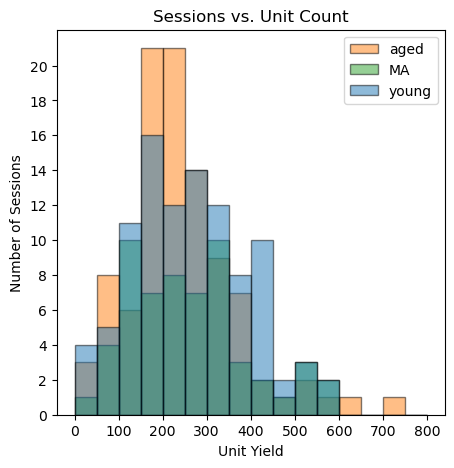

Session Cell Count Mean, SEM: 253.21653543307087, 8.068022071881277
Max Cell Count: 705.0, Lowest Cell Count 1.0

Young Session Cell Count Mean, SEM: 260.030303030303, 13.03544360782019
Max Young Cell Count: 597.0, Lowest Young Cell Count 1.0

MA Session Cell Count Mean, SEM: 258.8103448275862, 17.662621931314078
Max MA Cell Count: 582.0, Lowest MA Cell Count 41.0

Aged Session Cell Count Mean, SEM: 242.91752577319588, 12.633935969465778
Max Aged Cell Count: 705.0, Lowest MA Cell Count 36.0


In [12]:
''' Plot & report out total unit counts '''

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(all_counts_aged, bins = np.arange(0,850,50), edgecolor = 'black',alpha = 0.5, color = 'C1',label = 'aged')
ax.hist(all_counts_MA,  bins = np.arange(0,850,50), edgecolor = 'black', alpha = 0.5, color = 'C2',label = 'MA')
ax.hist(all_counts_young, bins = np.arange(0,850,50) , edgecolor = 'black', alpha = 0.5,color = 'C0', label = 'young')
plt.legend()
plt.title('Sessions vs. Unit Count')
plt.ylabel('Number of Sessions')
plt.xlabel('Unit Yield')
plt.yticks(np.arange(0,22,2))

#plt.savefig(save_folder + 'totalunityieldhisto.png', dpi=400, bbox_inches='tight') # save; adjust path
#plt.savefig(save_folder + 'totalunityieldhisto.svg', dpi=400, bbox_inches='tight') # save; adjust path
plt.show()

all_counts = np.concatenate((np.concatenate((all_counts_aged, all_counts_young)), all_counts_MA))
print('Session Cell Count Mean, SEM: ' + str(np.mean(all_counts)) + ', ' + str(stats.sem(all_counts)))
print('Max Cell Count: ' + str(np.amax(all_counts)) + ", Lowest Cell Count " + str(np.amin(all_counts)))

print('\nYoung Session Cell Count Mean, SEM: ' + str(np.mean(all_counts_young)) + ', ' + str(stats.sem(all_counts_young)))
print('Max Young Cell Count: ' + str(np.amax(all_counts_young)) + ", Lowest Young Cell Count " + str(np.amin(all_counts_young)))
      
print('\nMA Session Cell Count Mean, SEM: ' + str(np.mean(all_counts_MA)) + ', ' + str(stats.sem(all_counts_MA)))
print('Max MA Cell Count: ' + str(np.amax(all_counts_MA)) + ", Lowest MA Cell Count " + str(np.amin(all_counts_MA)))
      
print('\nAged Session Cell Count Mean, SEM: ' + str(np.mean(all_counts_aged)) + ', ' + str(stats.sem(all_counts_aged)))
print('Max Aged Cell Count: ' + str(np.amax(all_counts_aged)) + ", Lowest MA Cell Count " + str(np.amin(all_counts_aged)))